# Code for McArthur E & Capra JA paper: Topologically associating domain (TAD) boundaries stable across diverse cell types are evolutionarily constrained and enriched for heritability

Currently at: https://www.biorxiv.org/content/10.1101/2020.01.10.901967v2

## Upload packages, relevant data, helper functions

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns; sns.set(color_codes=True)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import sys
sys.setrecursionlimit(10000)
mpl.style.use('default')
from pybedtools import BedTool
import mygene
import re
import csv
import random
import os
from scipy import stats
import matplotlib.font_manager
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist, jaccard
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from sklearn import cluster


All Data is from 3d_genome_browser TAD coordinates generated from the Dixon 2012 paper pipeline (http://promoter.bx.psu.edu/hi-c/publications.html). To use on your own data, change the file paths in the 3DGenomeBrowser.key file (2nd column) to file paths for your downloaded 3D Genome Browser/TAD data.

In [7]:
with open('./data/3DGenomeBrowser.key') as f:
    reader = csv.reader(f, delimiter = "\t")
    input_file_list = list(reader)
    
cell_type_tads = {} # Upload all TAD maps into dictionary by cell-type

for line in input_file_list:
    cell_type_tads[line[1]] = pd.read_table(line[0], header=None)
    cell_type_tads[line[1]].columns = ['chr','start','stop']

# access data frames in the dictionary like this: cell_type_tads['A549_lungAdenocarcinoma_dekker'].head()

In [63]:
phastCons = BedTool('/dors/capra_lab/data/evolutionary_conservation/phastcons/hg19/phastConsElements46wayVertebrate.bed') #phastCons elements
listOfChroms = ['chr1', 'chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9','chr10','chr11','chr12','chr13','chr14','chr15','chr16','chr17','chr18','chr19','chr20','chr21','chr22','chrX']

In [45]:
class partitioned_h2(): 
    ''' Input partitioned heritabilty (S-LDSC) data'''
    def __init__(self, folder, file): #input options = 20binsTADlandscape/[celltype]
        self.folder = "./data/partitioned_h2/" + folder 
        self.file = file
    def enr(self):
        return(pd.read_csv("%s/%s/%s_enrichment.tsv" % (self.folder, self.file, self.file), sep='\t',index_col=0))
    def stderr(self):
        return(pd.read_csv("%s/%s/%s_stderr.tsv" % (self.folder, self.file, self.file), sep='\t',index_col=0))
    def pval(self):
        return(pd.read_csv("%s/%s/%s_pval.tsv" % (self.folder, self.file, self.file), sep='\t',index_col=0))
    def tau(self):
        return(pd.read_csv("%s/%s/%s_tau.tsv" % (self.folder, self.file, self.file), sep='\t',index_col=0))

#Example
partitioned_h2("20binsTADlandscape","HUVEC_Lieberman").enr().head()
partitioned_h2("boundaryStability","100kbBoundary_maintext").enr().head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,,,,,,,,,,,,,,,,,,,,
MorningPerson,0.948159,0.873441,0.929987,0.837811,0.935460,1.008355,1.082202,1.005893,0.919977,1.053787,1.123898,1.071777,1.004110,0.948266,0.890098,0.989347,1.099871,0.997442,1.030686,1.141069
YearsOfEd2,1.044326,0.928901,0.868824,0.844756,0.901448,1.069479,0.934475,0.909381,0.982063,0.944368,1.122424,1.153110,1.107535,0.973459,0.889218,0.980134,1.032569,0.942606,1.085646,1.025164
T2D2,1.199258,1.306641,1.221737,0.897575,0.833201,0.824801,1.112671,1.002023,1.185318,1.329862,1.382902,0.938974,0.715394,0.761629,0.570855,0.904214,0.893546,1.476332,1.443862,1.252057
SkinColor,0.761464,0.568362,0.670416,0.424155,0.773973,0.755944,0.868626,1.286210,0.672578,1.063985,1.202403,1.182367,0.742335,0.600739,1.659606,1.454782,0.701309,1.247858,0.979759,1.222744
Balding,0.901998,1.171198,1.126492,1.269183,0.676225,0.518084,0.949582,1.238064,1.029841,1.243755,1.328919,1.109362,0.947740,1.009752,0.771511,0.896029,0.891891,0.853132,0.915755,0.836361


,Q1of4_100kbBookendBoundaries_removeGaps.bed,Q2of4_100kbBookendBoundaries_removeGaps.bed,Q3of4_100kbBookendBoundaries_removeGaps.bed,Q4of4_100kbBookendBoundaries_removeGaps.bed
0,,,,
MorningPerson,0.894547,0.898457,0.989257,0.800268
YearsOfEd2,0.933770,1.063813,0.878043,0.883264
T2D2,0.902346,0.991582,1.133859,1.069699
SkinColor,1.448701,0.876553,1.232938,0.680129
Balding,0.613257,0.750818,1.021539,0.881723


In [54]:
def stabilityPercentileToQuartile(x):
    if x < 0.25:
        return 1
    elif x < 0.5:
        return 2
    elif x < 0.75:
        return 3
    else:
        return 4

## 20 bins across TAD landscape (+/- 50%)

In [179]:
tads_binned = {}
for key in cell_type_tads:
    #os.mkdir("./data/20binsTADlandscape/%s/" % key )
    binned=pd.DataFrame()
    binned['chr'] = cell_type_tads[key]['chr']
    diff = cell_type_tads[key]['stop'] - cell_type_tads[key]['start']
    binned['start'] = cell_type_tads[key]['start'] - (diff/2) # expand by 1/2 downstream
    binned['stop'] = cell_type_tads[key]['stop'] + (diff/2) # expand by 1/2 upstream
    
    tads_binned[key] = {}
    
    for j in range(1,21):
        tads_binned[key][j] = [] # intializing empty dictionaries
        
    for index,row in binned.iterrows():
        list_of_bins = np.linspace(row['start'], row['stop'], num=21) # split into 20 bins
        for k in range(1,21):
                tads_binned[key][k].append([row['chr'], list_of_bins[k-1], list_of_bins[k]-1])
    
    for l in range(1,21):
        tads_binned[key][l] = pd.DataFrame(np.vstack(tads_binned[key][l]))
        tads_binned[key][l].columns = ['chr','start','stop']
        tads_binned[key][l] = tads_binned[key][l].apply(pd.to_numeric, errors='ignore')
        tads_binned[key][l]['start'] = tads_binned[key][l]['start'].astype(int)
        tads_binned[key][l]['stop'] = tads_binned[key][l]['stop'].astype(int)
        tads_binned[key][l]['start'][tads_binned[key][l]['start'] < 0] = 0
        tads_binned[key][l]['stop'][tads_binned[key][l]['stop'] < 0] = 0
        tads_binned[key][l] = tads_binned[key][l][tads_binned[key][l]['stop'] > tads_binned[key][l]['start']]
        
        #tads_binned[key][l].to_csv("./data/20binsTADlandscape/%s/bin_%s_%s.bed" % (key, l, key), sep="\t",header=False,index=False)

/dors/capra_lab/users/evonne/resources/conda_envs/envs/evonne3/lib/python3.5/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/dors/capra_lab/users/evonne/resources/conda_envs/envs/evonne3/lib/python3.5/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Fig. 2A Heritability across TAD landscape

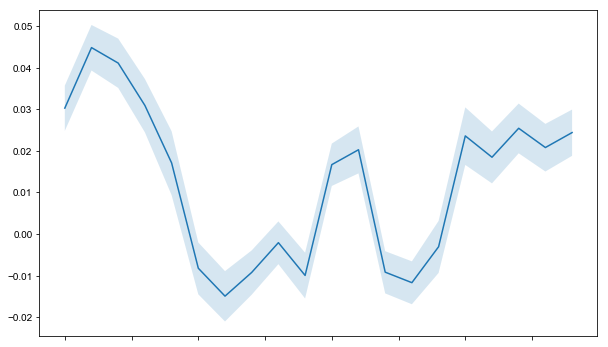

In [20]:
#Heritability enrichment results are calculated using S-LDSC with the above generated partition files

fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
aggregate_partition = pd.DataFrame()
trait_enrichments = {}

for key in cell_type_tads:
    partition = partitioned_h2("20binsTADlandscape",key).enr()
    aggregate_partition = pd.concat([aggregate_partition, partition],axis=0)
    for trait, row in partitioned_h2("20binsTADlandscape",key).enr().iterrows():
        if trait in trait_enrichments.keys():
            trait_enrichments[trait] =  trait_enrichments[trait].append(pd.DataFrame(row).transpose(), ignore_index=True)
        else:
            trait_enrichments[trait] = pd.DataFrame(row).transpose()

mean = aggregate_partition.describe().loc["mean",:]
error = 2.58*aggregate_partition.describe().loc["std",:]/np.sqrt(aggregate_partition.describe().loc["count",:])
np.log10(mean).plot(ax = ax)
ax.fill_between(range(0,20), np.log10(mean-error), np.log10(mean+error),alpha = 0.18)
#plt.savefig("/home/mcarthe/h2landscape.pdf")


In [210]:

outside = pd.concat([aggregate_partition.iloc[:,0:5],aggregate_partition.iloc[:,15:20]],axis=1) .melt()['value']
outside.mean()
inside = aggregate_partition.iloc[:,5:15].melt()['value']
inside.mean()
boundary = pd.concat([aggregate_partition.iloc[:,5],aggregate_partition.iloc[:,16]],axis=1) .melt()['value']

boundary.mean()
stats.ttest_ind(inside, outside)

stats.ttest_ind(inside, boundary)


1.0661069140280117

0.9931018353467116

1.0123220133979025

Ttest_indResult(statistic=-29.911550097085748, pvalue=9.115767063558435e-194)

Ttest_indResult(statistic=-4.8555193515281685, pvalue=1.2106808469766566e-06)

In [21]:
aggregate_partition.iloc[:,5:15].melt()['value'].describe()
pd.concat([aggregate_partition.iloc[:,0:5],aggregate_partition.iloc[:,15:20]],axis=1) .melt()['value'].describe()

#unequal variances:
stats.ttest_ind(aggregate_partition.iloc[:,5:15].melt()['value'],pd.concat([aggregate_partition.iloc[:,0:5],aggregate_partition.iloc[:,15:20]],axis=1).melt()['value'], equal_var = False)


count    15170.000000
mean         0.993102
std          0.194106
min         -0.005986
25%          0.886302
50%          0.989738
75%          1.095011
max          2.497918
Name: value, dtype: float64

count    15170.000000
mean         1.066107
std          0.229544
min          0.162055
25%          0.927437
50%          1.050287
75%          1.193156
max          2.476943
Name: value, dtype: float64

Ttest_indResult(statistic=-29.911550097085748, pvalue=1.086395028646265e-193)

### Fig. 2C Heritability across cell types

In [22]:
## Abbreviations
cell_type_mean = cell_type_mean.rename(index = {"A549_lungAdenocarcinoma_dekker":"A549",
"adrenal_schmitt2016":"adrenal",
"aorta_leung2015":"aorta",
"bladder_schmitt2016":"bladder",
"smallBowel_schmitt2016":"smallBowel",
"Caki2_clearCellRenalCellCarcinoma_dekker":"Caki2",
"cortex_DLPFC_schmitt2016":"DLPFC",
"G401_Wilms_tumor_dekker":"G401",
"GM12878_lymphoblastoid_Lieberman":"GM12878",
"H1_ESC_Dixon2015":"ESC",
"H1_mesendoderm_Dixon2015":"MES",
"H1_mesenchymalSC_Dixon2015":"MSC",
"H1_neuralSC_Dixon2015":"NPC",
"H1_trophoblastLike_Dixon2015":"TRO",
"HMEC_humanMammaryEpithelial_Lieberman":"HMEC",
"HUVEC_Lieberman":"HUVEC",
"IMR90_fetalLungFibroblast_Lieberman":"IMR90",
"K562_CML_Lieberman":"K562",
"KBM7_CML_Lieberman":"KBM7",
"Liver_leung2015":"Liver",
"LNCaP_prostateAdenocarcinoma_dekker":"LNCaP",
"lung_schmitt2016":"lung",
"psoasMuscle_schmitt2016":"psoas",
"NCIH460_NSCLC_dekker":"NCIH460",
"NHEK_epidermalKeratinocytes_Lieberman":"NHEK",
"PANC1_pancreaticCarcinoma_dekker":"PANC1",
"pancreas_schmitt2016":"pancreas",
"RPMI7951_melanoma_dekker":"RPMI7951",
"SJCRH30_BMrhabdomyosarcoma_dekker":"SJCRH30",
"SKMEL5_melanoma_dekker":"SKMEL5",
"SKNDZ_neurblastoma_dekker":"SKNDZ",
"SKNMC_neuroblastoma_dekker":"SKNMC",
"spleen_schmitt2016":"spleen",
"T470_breastCancer_dekker":"T470",
"thymus_leung2015":"thymus",
"leftVentricle_leung2015":"leftVentricle",
"rightVentricle_schmitt2016":"rightVentricle"})

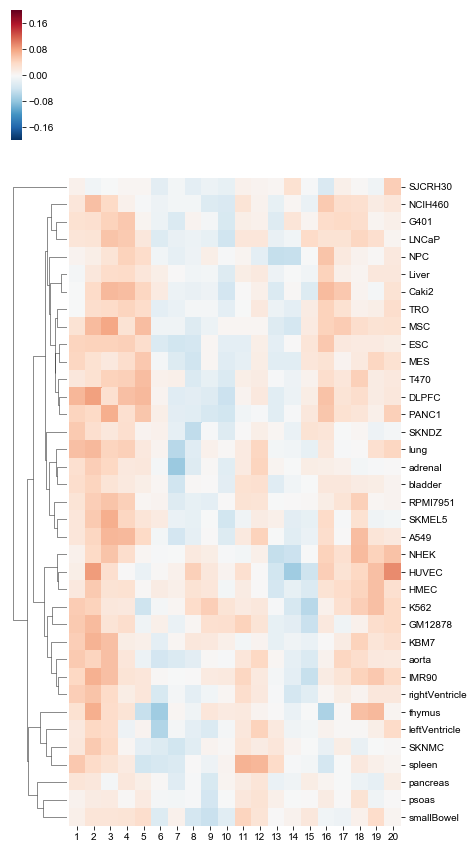

In [24]:
sns.clustermap(np.log10(cell_type_mean), figsize=(7,15), cmap="RdBu_r", method="average",metric='correlation', center = 0, col_cluster=False, vmin =-.2, vmax = .2)
#plt.savefig("/home/mcarthe/h2celltypes.pdf")

### Fig. 4A Heritability across traits

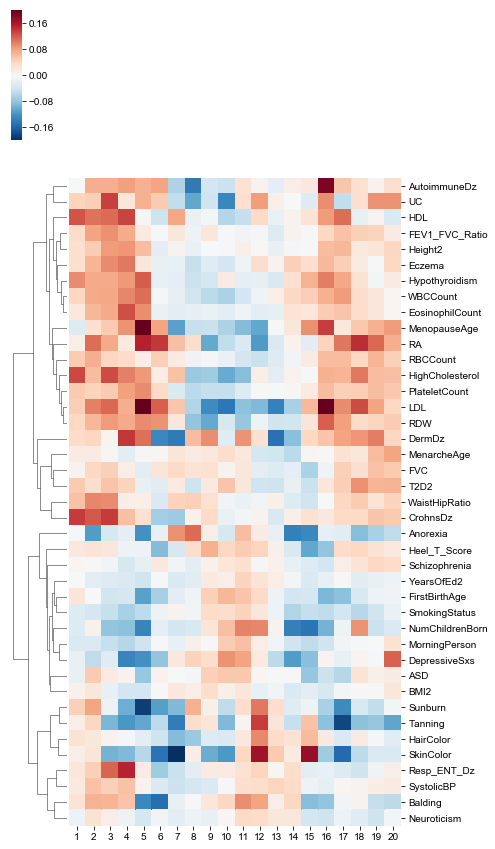

In [25]:
trait_mean = pd.DataFrame()
for key in trait_enrichments: 
    trait_mean = trait_mean.append(pd.DataFrame(trait_enrichments[key].mean(), columns = [key]).transpose())

sns.clustermap(np.log10(trait_mean), figsize=(7,15), cmap="RdBu_r", method="average",metric='correlation', center = 0, col_cluster=False, vmin =-.2, vmax = .2)
#plt.savefig("/home/mcarthe/h2traits.pdf")

#### Clustering traits by h2 patterns across TAD landscape

In [31]:
clustering = cluster.AgglomerativeClustering(n_clusters=2, affinity="correlation", linkage="average").fit(np.log10(trait_mean))
for i in np.log10(trait_mean).index[clustering.labels_ == 0]:
    print(i)
print(' ')   
for i in np.log10(trait_mean).index[clustering.labels_ == 1]:
    print(i)

Resp_ENT_Dz
Schizophrenia
Anorexia
Balding
MorningPerson
DepressiveSxs
NumChildrenBorn
SystolicBP
ASD
Sunburn
Heel_T_Score
YearsOfEd2
BMI2
HairColor
Neuroticism
SkinColor
Tanning
FirstBirthAge
SmokingStatus
 
WaistHipRatio
HighCholesterol
AutoimmuneDz
RA
CrohnsDz
MenarcheAge
Hypothyroidism
HDL
RBCCount
LDL
UC
PlateletCount
WBCCount
FVC
EosinophilCount
DermDz
T2D2
RDW
Eczema
MenopauseAge
FEV1_FVC_Ratio
Height2


In [32]:

psych_cluster = ["Schizophrenia",
"FirstBirthAge",
"ASD",
"Tanning",
"BMI2",
"YearsOfEd2",
"NumChildrenBorn",
"Sunburn",
"Anorexia",
"SkinColor",
"Heel_T_Score",
"HairColor",
"Resp_ENT_Dz",
"Balding",
"SmokingStatus",
"SystolicBP",
"DepressiveSxs",
"Neuroticism",
"MorningPerson"]

        
immuno_cluster = ["AutoimmuneDz",
"LDL",
"EosinophilCount",
"Hypothyroidism",
"Eczema",
"FVC",
"HighCholesterol",
"UC",
"PlateletCount",
"RBCCount",
"FEV1_FVC_Ratio",
"WaistHipRatio",
"RA",
"CrohnsDz",
"DermDz",
"WBCCount",
"Height2",
"HDL",
"MenarcheAge",
"RDW",
"T2D2",
"MenopauseAge",]

#### Fig. 4B & 4C

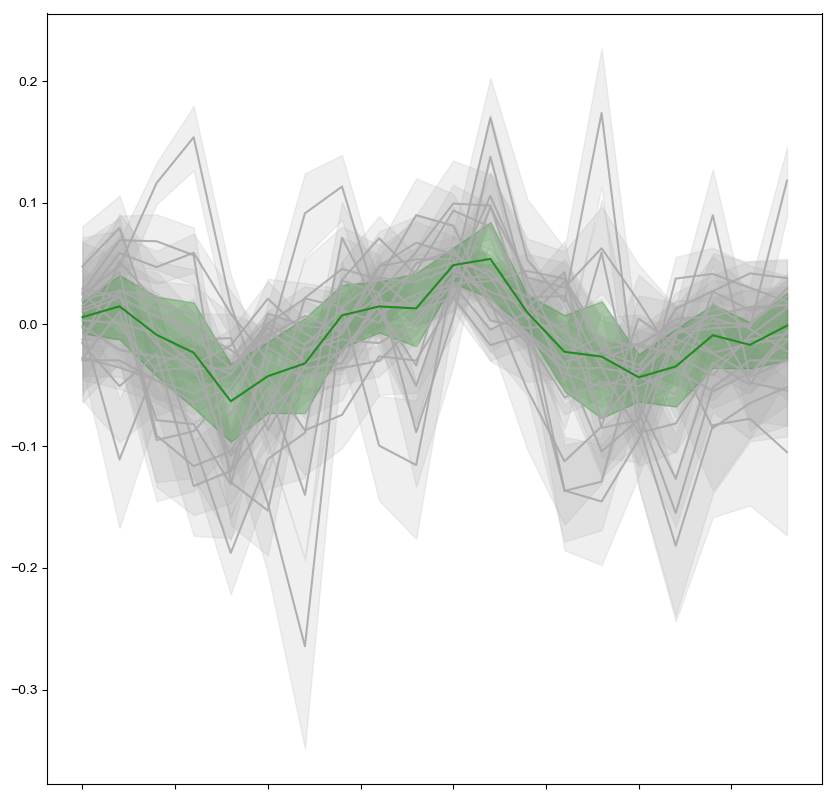

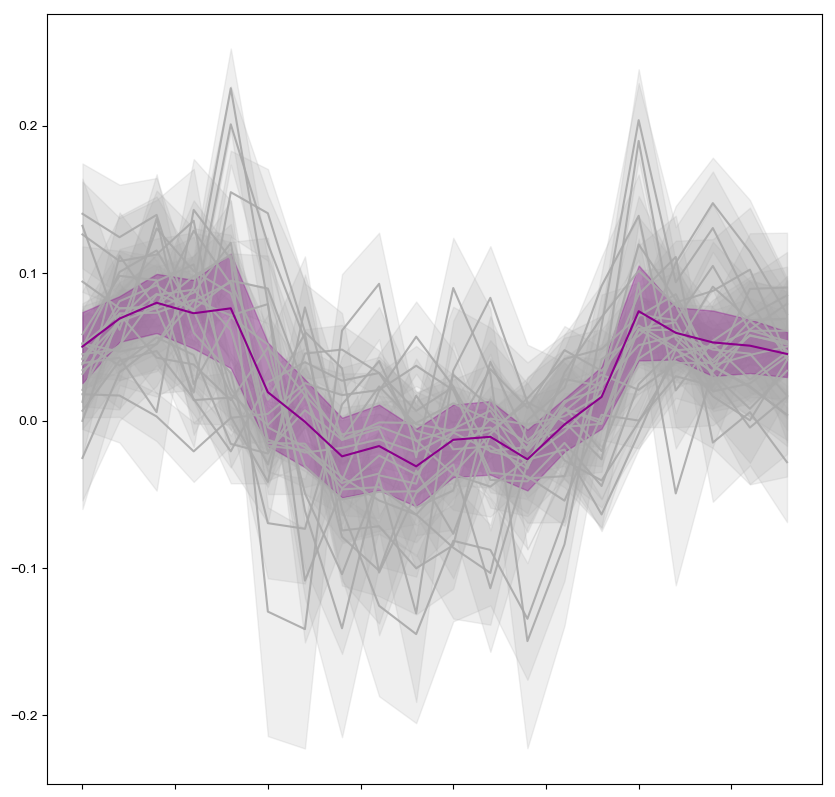

In [36]:

fig, ax = plt.subplots();
fig.set_size_inches(10, 10);
for i in psych_cluster:
    mean = trait_enrichments[i].describe().loc["mean",:]
    error = 2.58*trait_enrichments[i].describe().loc["std",:]/np.sqrt(trait_enrichments[i].describe().loc["count",:])
    np.log10(mean).plot(ax = ax, color="darkgray", alpha = 0.9)
    ax.fill_between(range(0,20), np.log10(mean-error), np.log10(mean+error),alpha = 0.18, color="darkgray")
mean = trait_mean[clustering.labels_ == 0].describe().loc["mean",:]
error = 2.58*trait_mean[clustering.labels_ == 0].describe().loc["std",:]/np.sqrt(trait_mean[clustering.labels_ == 0].describe().loc["count",:])
np.log10(mean).plot(ax = ax, color="forestgreen", alpha = 1)
ax.fill_between(range(0,20), np.log10(mean-error), np.log10(mean+error),alpha = 0.3, color="forestgreen")
#plt.savefig("/home/mcarthe/greencluster.pdf")
plt.show();

fig, ax = plt.subplots();
fig.set_size_inches(10, 10);
for i in immuno_cluster:
    mean = trait_enrichments[i].describe().loc["mean",:]
    error = 2.58*trait_enrichments[i].describe().loc["std",:]/np.sqrt(trait_enrichments[i].describe().loc["count",:])
    np.log10(mean).plot(ax = ax, color="darkgray", alpha = 0.9)
    ax.fill_between(range(0,20), np.log10(mean-error), np.log10(mean+error),alpha = 0.18, color="darkgray")
mean = trait_mean[clustering.labels_ == 1].describe().loc["mean",:]
error = 2.58*trait_mean[clustering.labels_ == 1].describe().loc["std",:]/np.sqrt(trait_mean[clustering.labels_ == 1].describe().loc["count",:])
np.log10(mean).plot(ax = ax, color="darkmagenta", alpha = 1)
ax.fill_between(range(0,20), np.log10(mean-error), np.log10(mean+error),alpha = 0.3, color="darkmagenta")
#plt.savefig("/home/mcarthe/purplecluster.pdf")
plt.show();



### Fig. 2B Conservation across TAD landscape

In [237]:
def conservationQuantification(regions, propBases=False, stability = False, minus=False):
        regions.columns = ['chr','start','stop'] + list(regions.columns)[3:]
        if stability:
            region_list = regions[['chr','start','stop', 'stability_percentile_group']]
            region_list.columns = ['chr','original_boundary_start','original_boundary_stop','stability_percentile_group']
        else:
            region_list = regions[['chr','start','stop']]
            region_list.columns = ['chr','original_boundary_start','original_boundary_stop']
        regions['original_boundary_start'] = regions['start']
        regions['original_boundary_stop'] = regions['stop']
        
        if minus != False:
            regions = regions.from_dataframe(regions)
            regions = regions.subtract(b=ctcf).to_dataframe()
            regions.columns = ['chr','start','stop'] + list(regions.columns)[3:]
            # will have to rename columns here probably
            #minusCTCF.columns=['chrom','TADboundary_start','TADboundary_stop','element','length','strand','original_boundary_start','original_boundary_stop']
        regions['region_size'] = regions['stop'] - regions['start']
        regions = regions.merge(regions.groupby(['chr', 'original_boundary_start','original_boundary_stop'],as_index=False).agg({'region_size': 'sum'}), on=['chr','original_boundary_start','original_boundary_stop'])#.reset_index()
        regions.drop('region_size_x',inplace=True,axis=1)
        regions = regions.rename(columns={'region_size_y':'region_size'})
        conserved = BedTool.from_dataframe(regions).intersect(phastCons, wo=True).to_dataframe(disable_auto_names=True, header=None)
        conserved.columns = list(regions.columns) + ['elem_chr','elem_start','elem_stop','lod','phastCons_score','numBases']
        
        if stability: 
            conserved = region_list.merge(conserved, on=['chr','original_boundary_start','original_boundary_stop', 'stability_percentile_group'], how='outer')
            conserved_grouped = conserved.groupby(['chr', 'original_boundary_start','original_boundary_stop']).agg({'numBases': 'sum','region_size':'mean','phastCons_score':'mean', 'stability_percentile_group':'mean'})
        else: 
            conserved = region_list.merge(conserved, on=['chr','original_boundary_start','original_boundary_stop'], how='outer')
            conserved_grouped = conserved.groupby(['chr', 'original_boundary_start','original_boundary_stop']).agg({'numBases': 'sum','region_size':'mean','phastCons_score':'mean'})
        
        if propBases:
            conserved_grouped['propBasesCovered'] = conserved_grouped['numBases']/conserved_grouped['region_size']
            conserved_grouped.loc[conserved_grouped['region_size'].isnull(),['numBases','propBasesCovered']] = 0
            numBases = conserved_grouped['propBasesCovered'].mean()
        else:
            numBases = conserved_grouped['numBases'].mean()
        
        score = conserved_grouped['phastCons_score'].mean()
        
        if stability:
            return conserved_grouped
        else:
            return conserved_grouped
            #return numBases, score

In [240]:
# takes a while ~1-2 hrs

conservation_acrossPartitions = []
for key in cell_type_tads:
    print(key)
    for l in range(1,21):
        print(l)
        bed = tads_binned[key][l]
        conserved_grouped = conservationQuantification(bed, propBases=True)
        propCoverPhastCons = conserved_grouped['numBases'].mean()/conserved_grouped['region_size'].mean()
        averagePhastConsScore = conserved_grouped['phastCons_score'].mean()
        conservation_acrossPartitions.append({'partitionNum': l, 'propCoverPhastCons': propCoverPhastCons, 'averagePhastConsScore': averagePhastConsScore})
        

leftVentricle_leung2015
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
aorta_leung2015
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
G401_Wilms_tumor_dekker
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
SJCRH30_BMrhabdomyosarcoma_dekker
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
Liver_leung2015
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
T470_breastCancer_dekker
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
NHEK_epidermalKeratinocytes_Lieberman
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
H1_trophoblastLike_Dixon2015
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
lung_schmitt2016
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
cortex_DLPFC_schmitt2016
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
NCIH460_NSCLC_dekker
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
H1_mesenchymalSC_Dixon2015
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
H1_ESC_Dixon2015
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
SKMEL5_melanoma_dekker
1

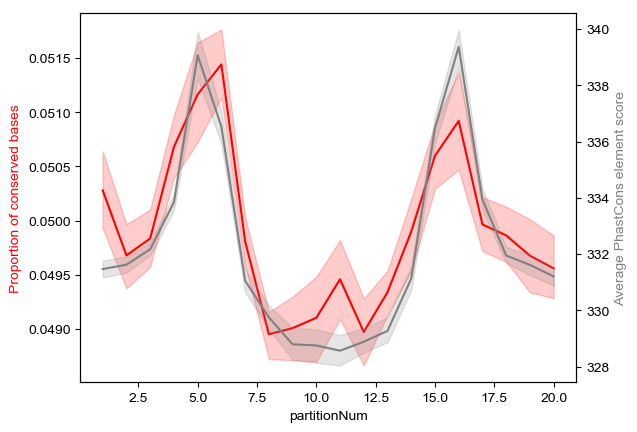

In [248]:
conservation_acrossPartitions = pd.DataFrame(conservation_acrossPartitions)#[['partitionNum','averagePhastConsScore']].melt()
conservation_acrossPartitions.index = conservation_acrossPartitions['partitionNum']

fig,ax = plt.subplots()
tmp = conservation_acrossPartitions[['propCoverPhastCons']].transpose().melt()
_ = sns.lineplot(x='partitionNum', y="value",data=tmp, ci=99, ax=ax, color='red')
_ = ax.set_ylabel("Proportion of conserved bases",color="red")
ax2 = ax.twinx()
_ = tmp = conservation_acrossPartitions[['averagePhastConsScore']].transpose().melt()
_ = sns.lineplot(x='partitionNum', y="value",data=tmp, ci=99, ax=ax2, color='gray')
_ = ax2.set_ylabel("Average PhastCons element score",color="gray")
plt.savefig("/home/mcarthe/conservation_landscape_new2.pdf")
plt.show()

In [259]:
inside = conservation_acrossPartitions[(conservation_acrossPartitions['partitionNum'] >=6) & (conservation_acrossPartitions['partitionNum'] <=15)]
outside = conservation_acrossPartitions[(conservation_acrossPartitions['partitionNum'] <=5) | (conservation_acrossPartitions['partitionNum'] >=16)]
boundary = conservation_acrossPartitions[(conservation_acrossPartitions['partitionNum'] ==5) | (conservation_acrossPartitions['partitionNum'] ==16)]

inside.describe()
outside.describe()
boundary.describe()

stats.ttest_ind(inside['propCoverPhastCons'],outside['propCoverPhastCons'])
stats.ttest_ind(inside['averagePhastConsScore'],outside['averagePhastConsScore'])

stats.ttest_ind(inside['propCoverPhastCons'],boundary['propCoverPhastCons'])
stats.ttest_ind(inside['averagePhastConsScore'],boundary['averagePhastConsScore'])




,averagePhastConsScore,partitionNum,propCoverPhastCons
count,370.000000,370.000000,370.000000
mean,330.921798,10.500000,0.049658
std,3.165072,2.876171,0.001068
min,325.563635,6.000000,0.047020
25%,328.788690,8.000000,0.048879
50%,330.058007,10.500000,0.049599
75%,331.831220,13.000000,0.050276
max,339.644304,15.000000,0.053127


,averagePhastConsScore,partitionNum,propCoverPhastCons
count,370.000000,370.000000,370.000000
mean,333.628295,10.500000,0.050162
std,3.114940,7.642503,0.000967
min,329.673408,1.000000,0.048062
25%,331.495358,3.000000,0.049498
50%,332.386677,10.500000,0.050038
75%,334.287329,18.000000,0.050712
max,343.748917,20.000000,0.053518


,averagePhastConsScore,partitionNum,propCoverPhastCons
count,74.000000,74.000000,74.000000
mean,339.225790,10.500000,0.051043
std,1.747082,5.537543,0.001137
min,334.200195,5.000000,0.048062
25%,338.425378,5.000000,0.050223
50%,339.340944,10.500000,0.051151
75%,340.317398,16.000000,0.051814
max,343.748917,16.000000,0.053518


Ttest_indResult(statistic=-6.73286212055425, pvalue=3.34461545665209e-11)

Ttest_indResult(statistic=-11.723278200947956, pvalue=3.1539986492595604e-29)

Ttest_indResult(statistic=-10.07631129048276, pvalue=1.2379328215471343e-21)

Ttest_indResult(statistic=-21.898618118246215, pvalue=1.5835342082226462e-72)

## Bin boundaries & investigate their stability across cell types

In [56]:
def binBoundaries(cell_type_tads, boundary_size, bin_size = 40000, centered = True, flatten = True, only_counts=False):
    # Input: 
    # cell_type_tads: whole cell types tad dictionary of pandas dataframe with chr, start, stop
    # boundary_size: size of resulting TAD boundaries
    # bin_size: the resolution of the bins you want to define, a good default is 40,000
    # centered: should the bins be centered around the start-end point? (if False: will generate boundaries bookending the TAD)
    # flatten: True if you don't care if a cell type has both a start and stop boundary or just 1 - you just care if there is 1+boundary per tissue type, if you don't flatten, it will return 1 for 1 boundary and 2 for both a start and stop boundary in one location
    # only_counts - binary that will specificy that you don't care what tissues the boundaries are in, you just want the counts per each bin
    # returns dataframe with binned boundaries and counts of observations(a boundary) within each bin per cell type tissue (or agnostic of the cell type tissue if only_counts=True)
    # sample usage: boundaries = binBoundaries(cell_type_tads)
    allBoundaries = pd.DataFrame() 
    allBoundaries['chr'] = 0

    for key, value in cell_type_tads.items():
        start = value.loc[:,['chr','start']]
        start.columns = ['chr','loc']
        if centered:
            start['loc'] = ((start['loc']/ bin_size).apply(np.floor).astype(int) * bin_size) - (boundary_size/2)
        else:
            start['loc'] = ((start['loc']/ bin_size).apply(np.floor).astype(int) * bin_size) - boundary_size
        stop = value.loc[:,['chr','stop']]
        stop.columns = ['chr','loc']
        if centered:
            stop['loc'] = ((stop['loc']/ bin_size).apply(np.floor).astype(int) * bin_size) - (boundary_size/2)
        else:
            stop['loc'] = ((stop['loc']/ bin_size).apply(np.floor).astype(int) * bin_size)
        start_and_stop = start.append(stop)
        start_and_stop['loc2'] = start_and_stop['loc'] + (boundary_size)
        if (flatten):
            start_and_stop.drop_duplicates(inplace=True)
        start_and_stop = start_and_stop.groupby(['chr', 'loc','loc2']).size().reset_index(name=key).astype(int, errors = 'ignore') # group the boundaries by their duplicates and add a counts column
        
        #!
        #start_and_stop['loc'] = start_and_stop['loc'].clip_lower(0)
        #start_and_stop = start_and_stop[start_and_stop['loc2'] > start_and_stop['loc']]
        #start_and_stop[['chr','loc','loc2']].to_csv("/dors/capra_lab/users/evonne/TAD/paper/data_forGithub/40kbBoundaries_byCellType/" + key + ".bed", sep="\t",header=False, index=False)
        #value.loc[:,['start','stop']] = (value.loc[:,['start','stop']]/bin_size).apply(np.floor).astype(int)* bin_size
        #value.to_csv("~/3d_boundaries/" + key, sep="\t",header=False, index=False)

        allBoundaries = allBoundaries.merge(start_and_stop, how='outer', sort=True)
        
    if(only_counts):
        sums = allBoundaries.iloc[:,3:].sum(axis=1, skipna=True)
        allBoundaries = allBoundaries.iloc[:,0:3]
        allBoundaries['counts'] = sums
    allBoundaries['loc'] = allBoundaries['loc'].clip_lower(0)

    return(allBoundaries[allBoundaries['loc2'] > allBoundaries['loc']])


### 100 kb bookended boundary definition

In [255]:
boundaries_100kbBookend = binBoundaries(cell_type_tads, boundary_size = 100000, bin_size = 100000, centered = False, flatten = True, only_counts=True)

# Remove overlap with genomic gap regions
boundariesBed = BedTool.from_dataframe(boundaries_100kbBookend)
gap_regions = BedTool('./data/gap_regions_hg19.bed').sort()
boundaries_intersectWithGaps = boundariesBed.intersect(gap_regions,wa=True).to_dataframe(disable_auto_names=False, header=None)
boundaries_intersectWithGaps.columns = ['chr','loc','loc2','counts'] 
boundaries_100kbBookend_removeGapRegions = pd.merge(boundaries_100kbBookend, boundaries_intersectWithGaps, how='outer', indicator=True)
boundaries_100kbBookend_removeGapRegions = boundaries_100kbBookend_removeGapRegions[boundaries_100kbBookend_removeGapRegions['_merge'] == "left_only"][['chr','loc','loc2','counts']]
print("num boundaries removed bc of gap region overlap: ")
len(boundaries_100kbBookend) - len(boundaries_100kbBookend_removeGapRegions)
print("out of")
len(boundaries_100kbBookend)
boundaries_100kbBookend_removeGapRegions['stability_percentile'] = boundaries_100kbBookend_removeGapRegions['counts'].rank(pct=True)
#boundaries_100kbBookend_removeGapRegions.to_csv("./data/100kbBookendBoundaries_byStability.bed",index=False, sep="\t")

num boundaries removed bc of gap region overlap: 


309

out of


14654

#### Fig 3B

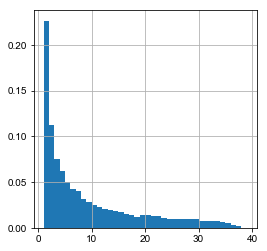

<Figure size 288x288 with 0 Axes>

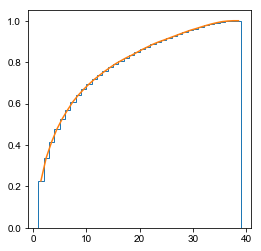

1.0

4.0

13.0

0.09369118159637504

0.22628093412338793

In [5]:
boundaries = boundaries_100kbBookend_removeGapRegions
_ = boundaries['counts'].hist(bins=np.linspace(1,39,39), density=True, figsize=(4,4))
#plt.savefig("/home/mcarthe/100kbBoundaries_hist.pdf")
plt.show()
plt.figure(figsize = (4,4))
n,x,_ = plt.hist(boundaries['counts'], bins=np.linspace(1,39,39),density=True, cumulative=True, histtype='step')
bin_centers = 0.5*(x[1:]+x[:-1])
_ = plt.plot(bin_centers,n)
#plt.savefig("/home/mcarthe/100kbBoundaries_cdf.pdf")

_ = plt.show()

max(boundaries[boundaries['stability_percentile'] < 0.25]['counts'])
max(boundaries[boundaries['stability_percentile'] < 0.5]['counts'])
max(boundaries[boundaries['stability_percentile'] < 0.75]['counts'])


len(boundaries[boundaries['counts'] >= 25])/len(boundaries)
len(boundaries[boundaries['counts'] == 1])/len(boundaries)

#### Separate by boundary stability

In [6]:
len(boundaries_100kbBookend_removeGapRegions[(boundaries_100kbBookend_removeGapRegions['stability_percentile'] > 0) & (boundaries_100kbBookend_removeGapRegions['stability_percentile'] < 0.25)])
len(boundaries_100kbBookend_removeGapRegions[(boundaries_100kbBookend_removeGapRegions['stability_percentile'] > .25) & (boundaries_100kbBookend_removeGapRegions['stability_percentile'] < 0.5)])
len(boundaries_100kbBookend_removeGapRegions[(boundaries_100kbBookend_removeGapRegions['stability_percentile'] > .5) & (boundaries_100kbBookend_removeGapRegions['stability_percentile'] < 0.75)])
len(boundaries_100kbBookend_removeGapRegions[(boundaries_100kbBookend_removeGapRegions['stability_percentile'] > .75) & (boundaries_100kbBookend_removeGapRegions['stability_percentile'] < 1)])
   
#Export
#boundaries_100kbBookend_removeGapRegions[(boundaries_100kbBookend_removeGapRegions['stability_percentile'] > 0) & (boundaries_100kbBookend_removeGapRegions['stability_percentile'] < 0.25)][['chr','loc','loc2']].to_csv("Q1of4_100kbBookendBoundaries_removeGaps.bed",sep="\t",index=False, header=False)
#boundaries_100kbBookend_removeGapRegions[(boundaries_100kbBookend_removeGapRegions['stability_percentile'] > .25) & (boundaries_100kbBookend_removeGapRegions['stability_percentile'] < 0.5)][['chr','loc','loc2']].to_csv("Q2of4_100kbBookendBoundaries_removeGaps.bed",sep="\t",index=False, header=False)
#boundaries_100kbBookend_removeGapRegions[(boundaries_100kbBookend_removeGapRegions['stability_percentile'] > .5) & (boundaries_100kbBookend_removeGapRegions['stability_percentile'] < 0.75)][['chr','loc','loc2']].to_csv("Q3of4_100kbBookendBoundaries_removeGaps.bed",sep="\t",index=False, header=False)
#boundaries_100kbBookend_removeGapRegions[(boundaries_100kbBookend_removeGapRegions['stability_percentile'] > .75) & (boundaries_100kbBookend_removeGapRegions['stability_percentile'] < 1)][['chr','loc','loc2']].to_csv("Q4of4_100kbBookendBoundaries_removeGaps.bed",sep="\t",index=False, header=False)

3246

3590

4021

3488

#### Suppl Fig. Jaccard similiarity 

/dors/capra_lab/users/evonne/resources/conda_envs/envs/evonne3/lib/python3.5/site-packages/pybedtools/bedtool.py:3433: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 40 fields; you can supply custom names with the `names` kwarg
  % (self.file_type, _names, self.field_count()))


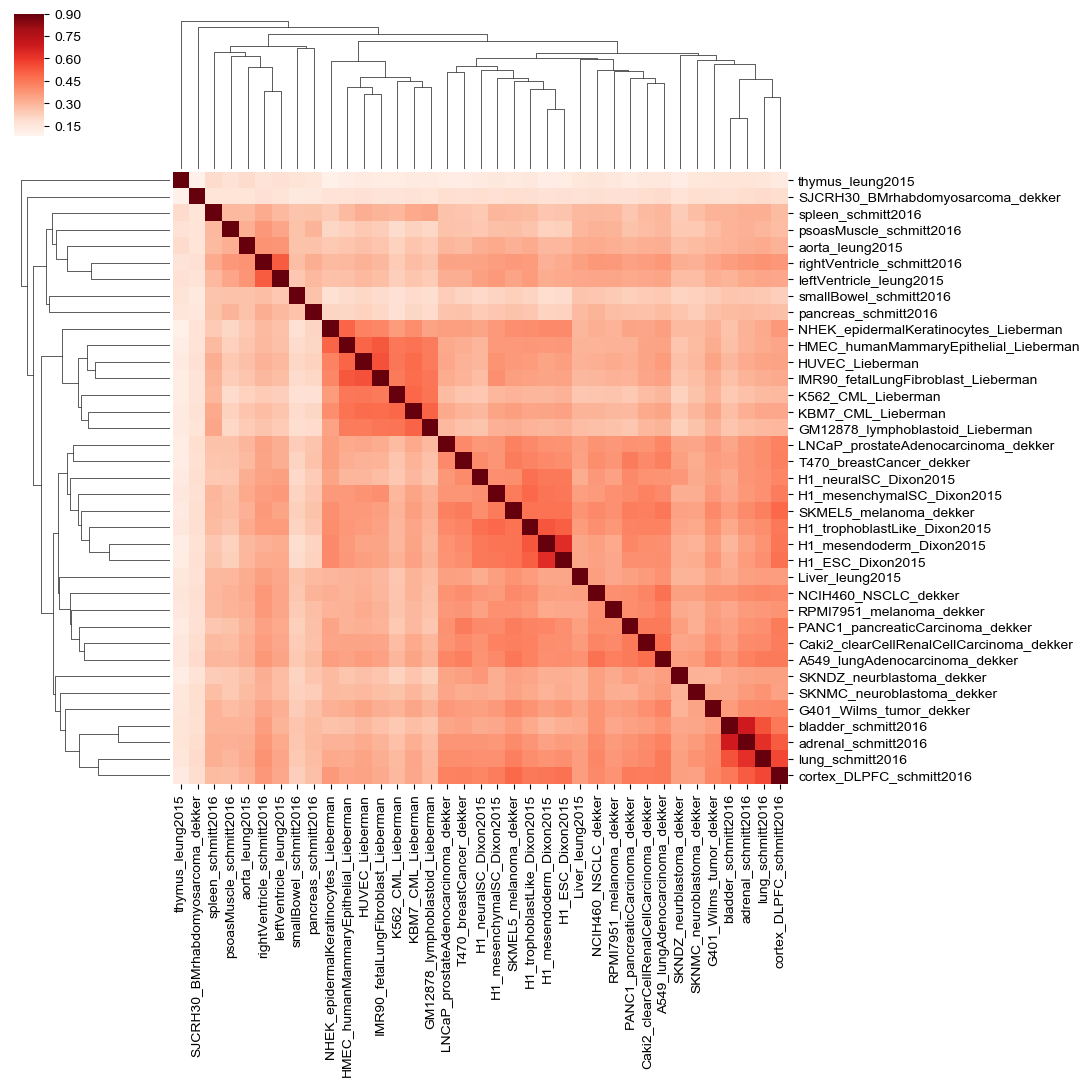

In [11]:
# Boundaries by tissue
boundaries_tissueSpecific = binBoundaries(cell_type_tads,boundary_size = 100000, bin_size = 100000, centered = False, flatten = True, only_counts=False)
boundaries_tissueSpecific = boundaries_tissueSpecific.fillna(0)
boundariesBed = BedTool.from_dataframe(boundaries_tissueSpecific)
gap_regions = BedTool('./data/gap_regions_hg19.bed').sort()
boundaries_intersectWithGaps = boundariesBed.intersect(gap_regions,wa=True).to_dataframe(disable_auto_names=False, header=None)
boundaries_intersectWithGaps.columns = boundaries_tissueSpecific.columns
boundaries_tissueSpecific_removeGapRegions = pd.merge(boundaries_tissueSpecific, boundaries_intersectWithGaps, how='outer', indicator=True)
boundaries_tissueSpecific_removeGapRegions = boundaries_tissueSpecific_removeGapRegions[boundaries_tissueSpecific_removeGapRegions['_merge'] == "left_only"]

# Jaccard similarity matrix

res = pdist(boundaries_tissueSpecific.drop(['chr','loc','loc2'],axis=1).transpose(),'jaccard') # can also look at hamming
similarity = 1 - pd.DataFrame(squareform(res))

similarity.columns = boundaries_tissueSpecific.drop(['chr','loc','loc2'],axis=1).columns
similarity.index = boundaries_tissueSpecific.drop(['chr','loc','loc2'],axis=1).columns

linkage = hc.linkage(sp.distance.squareform(1 - similarity), method='complete')
g = sns.clustermap(similarity, cmap="Reds", vmin=0.08, vmax=0.9, row_linkage=linkage, col_linkage=linkage)
#for i in [similarity.index[i] for i in g.dendrogram_col.reordered_ind]:
#    i
g = plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0) # rotating the y-axis labels
#https://stackoverflow.com/questions/35639571/python-pandas-distance-matrix-using-jaccard-similarity
# https://stackoverflow.com/questions/38705359/how-to-give-sns-clustermap-a-precomputed-distance-matrix
#plt.savefig("/home/mcarthe/100kbSimilarityMatrix.pdf")

In [12]:
# Some quantifications of jaccard similiary across TAD maps of all these cell types
similarity[similarity!=1].melt().describe()
subset = similarity.loc[['GM12878_lymphoblastoid_Lieberman'],['HUVEC_Lieberman','IMR90_fetalLungFibroblast_Lieberman','K562_CML_Lieberman','HMEC_humanMammaryEpithelial_Lieberman','NHEK_epidermalKeratinocytes_Lieberman','KBM7_CML_Lieberman']]
subset.min().min()
subset.max().max()

,value
count,1332.000000
mean,0.316826
std,0.088103
min,0.102179
25%,0.264253
50%,0.317703
75%,0.371474
max,0.688304


0.34728253717594415

0.5041416738074835

#### 100 kb boundaries minus gaps or blacklist regions within 5 MB

In [ ]:
# Generating dataframe of 100 kb boundaries minus any boundaries within 5 MB of gaps or blacklist regions
boundaries_100kbBookend = binBoundaries(cell_type_tads, boundary_size = 100000, bin_size = 100000, centered = False, flatten = True, only_counts=True)

boundariesBed = BedTool.from_dataframe(boundaries_100kbBookend)

gap_regions = BedTool('./data/blacklist_plus_gaps_hg19.bed').sort().slop(b=5000000, genome='hg19')
    
boundaries_intersectWithGaps = boundariesBed.intersect(gap_regions,wa=True).to_dataframe(disable_auto_names=False, header=None)
boundaries_intersectWithGaps.columns = ['chr','loc','loc2','counts'] 
boundaries_100kbBookend_removeGapRegions = pd.merge(boundaries_100kbBookend, boundaries_intersectWithGaps, how='outer', indicator=True)
boundaries_100kbBookend_removeGapRegions = boundaries_100kbBookend_removeGapRegions[boundaries_100kbBookend_removeGapRegions['_merge'] == "left_only"][['chr','loc','loc2','counts']]
boundaries_100kbBookend = boundaries_100kbBookend_removeGapRegions
boundaries_100kbBookend['stability_percentile'] = boundaries_100kbBookend['counts'].rank(pct=True)
    
boundaries_100kbBookend.head()

#### Suppl Heritability across all 100 kb boundaries

/dors/capra_lab/users/evonne/resources/conda_envs/envs/evonne3/lib/python3.5/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


[Text(0, 0, 'All Traits'),
 Text(0, 0, 'Boundary-enriched Traits'),
 Text(0, 0, 'Boundary-depleted Traits')]

100kbBookendBoundaries_byStability.bed    1.045192
dtype: float64

100kbBookendBoundaries_byStability.bed    1.06947
dtype: float64

array([0.00116479])

100kbBookendBoundaries_byStability.bed    1.172922
dtype: float64

100kbBookendBoundaries_byStability.bed    1.16418
dtype: float64

array([1.49246553e-07])

100kbBookendBoundaries_byStability.bed    0.971011
dtype: float64

100kbBookendBoundaries_byStability.bed    0.969391
dtype: float64

array([0.06141574])

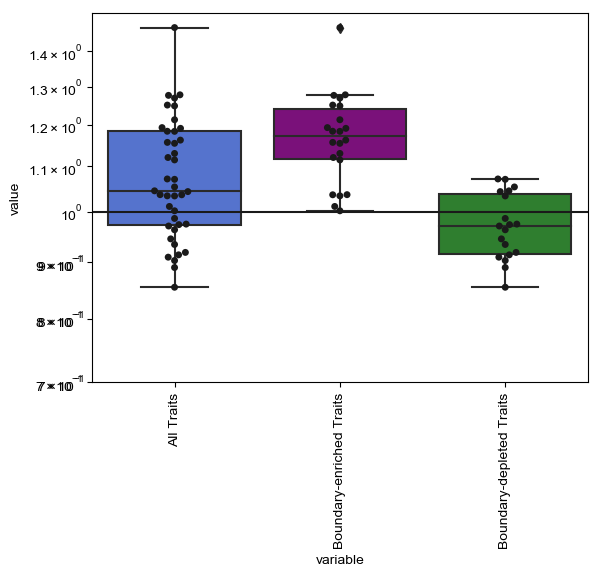

In [199]:
enr = partitioned_h2("boundaryStability","100kbBoundaries_noStabilityStrat_suppl").enr()
enr_immuno = partitioned_h2("boundaryStability","100kbBoundaries_noStabilityStrat_suppl").enr().loc[immuno_cluster]
enr_psych = partitioned_h2("boundaryStability","100kbBoundaries_noStabilityStrat_suppl").enr().loc[psych_cluster]

enr.columns = ['All Traits']
enr_immuno.columns = ['Boundary-enriched Traits']
enr_psych.columns = ['Boundary-depleted Traits']
enr = pd.concat([enr,enr_immuno,enr_psych],axis=1)
g = sns.boxplot(y='value',x='variable',data=enr.melt(), palette ={'All Traits': "royalblue", "Boundary-enriched Traits": "darkmagenta", "Boundary-depleted Traits":"forestgreen"})
sns.swarmplot(y='value',x='variable',data=enr.melt(), color='k')
g.set_xticklabels(g.get_xticklabels(), rotation=90)
_ = g.set(yscale="log")
_ = g.set(yticks=[0.7, 0.8, 0.9, 1, 1.1, 1.2,1.3, 1.4])

plt.axhline(y=1, color='k')

enr = partitioned_h2("boundaryStability","100kbBoundaries_noStabilityStrat_suppl").enr()
enr.median()
enr = np.log(enr)
t = np.mean(enr)/(np.std(enr,ddof=1)/np.sqrt(len(enr)))
pval = 2*stats.t.cdf(-abs(t),len(enr)-1)
np.exp(np.mean(enr))
pval

enr = partitioned_h2("boundaryStability","100kbBoundaries_noStabilityStrat_suppl").enr().loc[immuno_cluster]
enr.median()
enr = np.log(enr)
t = np.mean(enr)/(np.std(enr,ddof=1)/np.sqrt(len(enr)))
pval = 2*stats.t.cdf(-abs(t),len(enr)-1)
np.exp(np.mean(enr))
pval

enr = partitioned_h2("boundaryStability","100kbBoundaries_noStabilityStrat_suppl").enr().loc[psych_cluster]
enr.median()
enr = np.log(enr)
t = np.mean(enr)/(np.std(enr,ddof=1)/np.sqrt(len(enr)))
pval = 2*stats.t.cdf(-abs(t),len(enr)-1)
np.exp(np.mean(enr))
pval

In [ ]:

#100kbBoundaries_noStabilityStrat_suppl
enr = readInEnrichmentNoLog('quantifyTADandBoundaryOverlap').loc[immuno_cluster + psych_cluster, ["100kbBookendBoundaries_byStability.bed","boundariesSubtractOverlap_middle10.bed", "boundariesSubtractOverlap_middle20.bed","boundariesWithNoOverlap_middle10.bed","boundariesWithNoOverlap_middle20.bed"]]

sns.swarmplot(x='value',y=0,data=enr.melt())
plt.axvline(x=1, color='k')
plt.show()
enr = readInEnrichmentNoLog('quantifyTADandBoundaryOverlap').loc[immuno_cluster , ["100kbBookendBoundaries_byStability.bed","boundariesSubtractOverlap_middle10.bed", "boundariesSubtractOverlap_middle20.bed","boundariesWithNoOverlap_middle10.bed","boundariesWithNoOverlap_middle20.bed"]]
sns.swarmplot(x='value',y=0,data=enr.melt())
plt.axvline(x=1, color='k')

plt.show()

enr = readInEnrichmentNoLog('quantifyTADandBoundaryOverlap').loc[ psych_cluster, ["100kbBookendBoundaries_byStability.bed","boundariesSubtractOverlap_middle10.bed", "boundariesSubtractOverlap_middle20.bed","boundariesWithNoOverlap_middle10.bed","boundariesWithNoOverlap_middle20.bed"]]
sns.swarmplot(x='value',y=0,data=enr.melt())
plt.axvline(x=1, color='k')

plt.show()

enr1 = readInEnrichmentNoLog('quantifyTADandBoundaryOverlap').loc[immuno_cluster + psych_cluster, ["100kbBookendBoundaries_byStability.bed"]]
enr2 = readInEnrichmentNoLog('quantifyTADandBoundaryOverlap').loc[immuno_cluster, ["100kbBookendBoundaries_byStability.bed"]]
enr3 = readInEnrichmentNoLog('quantifyTADandBoundaryOverlap').loc[psych_cluster, ["100kbBookendBoundaries_byStability.bed"]]
enr1.columns = ['All Traits']
enr2.columns = ['Boundary-enriched Traits']
enr3.columns = ['Boundary-depleted Traits']
enr = pd.concat([enr1,enr2,enr3],axis=1)
g = sns.boxplot(y='value',x='variable',data=enr.melt(), palette ={'All Traits': "royalblue", "Boundary-enriched Traits": "darkmagenta", "Boundary-depleted Traits":"forestgreen"})
sns.swarmplot(y='value',x='variable',data=enr.melt(), color='k')
g.set_xticklabels(g.get_xticklabels(), rotation=90)
_ = g.set(yscale="log")
_ = g.set(yticks=[0.7, 0.8, 0.9, 1, 1.1, 1.2,1.3, 1.4])

plt.axhline(y=1, color='k')
#plt.savefig("/home/mcarthe/100kbTADboundaryH2.pdf")

enr1 = readInEnrichmentNoLog('quantifyTADandBoundaryOverlap').loc[immuno_cluster + psych_cluster, ["100kbBookendBoundaries_byStability.bed"]]
enr1.median()
enr1 = np.log(enr1)
t = np.mean(enr1)/(np.std(enr1,ddof=1)/np.sqrt(len(enr1)))
pval = 2*stats.t.cdf(-abs(t),len(enr1)-1)
np.exp(np.mean(enr1))
pval

enr1 = readInEnrichmentNoLog('quantifyTADandBoundaryOverlap').loc[immuno_cluster, ["100kbBookendBoundaries_byStability.bed"]]
enr1.median()
enr1 = np.log(enr1)
t = np.mean(enr1)/(np.std(enr1,ddof=1)/np.sqrt(len(enr1)))
pval = 2*stats.t.cdf(-abs(t),len(enr1)-1)
np.exp(np.mean(enr1))
pval

enr1 = readInEnrichmentNoLog('quantifyTADandBoundaryOverlap').loc[psych_cluster, ["100kbBookendBoundaries_byStability.bed"]]
enr1.median()
enr1 = np.log(enr1)
t = np.mean(enr1)/(np.std(enr1,ddof=1)/np.sqrt(len(enr1)))
pval = 2*stats.t.cdf(-abs(t),len(enr1)-1)
np.exp(np.mean(enr1))
pval




### Suppl. 40 kb boundary definitions

In [159]:
boundaries_40kb = binBoundaries(cell_type_tads, boundary_size = 40000, bin_size = 40000, centered = True, flatten = True, only_counts=True)

# Remove overlap with genomic gap regions
boundariesBed = BedTool.from_dataframe(boundaries_40kb)
gap_regions = BedTool('/dors/capra_lab/users/evonne/resources/blacklist/gap_regions_hg19.bed').sort()
boundaries_intersectWithGaps = boundariesBed.intersect(gap_regions,wa=True).to_dataframe(disable_auto_names=False, header=None)
boundaries_intersectWithGaps.columns = ['chr','loc','loc2','counts'] 
boundaries_40kb_removeGapRegions = pd.merge(boundaries_40kb, boundaries_intersectWithGaps, how='outer', indicator=True)
boundaries_40kb_removeGapRegions = boundaries_40kb_removeGapRegions[boundaries_40kb_removeGapRegions['_merge'] == "left_only"][['chr','loc','loc2','counts']]
print("num boundaries removed bc of gap region overlap: ")
len(boundaries_40kb) - len(boundaries_40kb_removeGapRegions)
print("out of")
len(boundaries_40kb)
boundaries_40kb_removeGapRegions['stability_percentile'] = boundaries_40kb_removeGapRegions['counts'].rank(pct=True)
#boundaries_40kb_removeGapRegions.to_csv("./data/40kbBoundaries_byStability.bed",index=False, sep="\t")

num boundaries removed bc of gap region overlap: 


335

out of


23553

#### Suppl 40 kb stability histogram

,chr,loc,loc2,counts,stability_percentile
1,chr1,20000,60000,4.0,0.610195
3,chr1,580000,620000,1.0,0.169459
4,chr1,620000,660000,4.0,0.610195
5,chr1,660000,700000,13.0,0.889676
6,chr1,700000,740000,6.0,0.718387


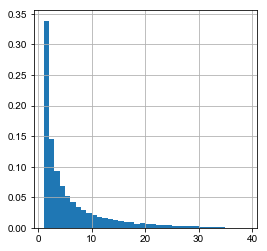

1.0

2.0

6.0

0.019726074597295203

0.338875010767508

In [8]:
boundaries = boundaries_40kb_removeGapRegions
boundaries.head()
_ = boundaries['counts'].hist(bins=np.linspace(1,39,39), density=True, figsize=(4,4))
#plt.savefig("/home/mcarthe/40kbBoundaries_hist.pdf")
_ = plt.show()

max(boundaries[boundaries['stability_percentile'] < 0.25]['counts'])
max(boundaries[boundaries['stability_percentile'] < 0.5]['counts'])
max(boundaries[boundaries['stability_percentile'] < 0.75]['counts'])


len(boundaries[boundaries['counts'] >= 25])/len(boundaries)
len(boundaries[boundaries['counts'] == 1])/len(boundaries)

#### Separate by boundary stability

In [10]:
# Export
len(boundaries_40kb_removeGapRegions[(boundaries_40kb_removeGapRegions['stability_percentile'] > 0) & (boundaries_40kb_removeGapRegions['stability_percentile'] < 0.25)])
len(boundaries_40kb_removeGapRegions[(boundaries_40kb_removeGapRegions['stability_percentile'] > .25) & (boundaries_40kb_removeGapRegions['stability_percentile'] < 0.5)])
len(boundaries_40kb_removeGapRegions[(boundaries_40kb_removeGapRegions['stability_percentile'] > .5) & (boundaries_40kb_removeGapRegions['stability_percentile'] < 0.75)])
len(boundaries_40kb_removeGapRegions[(boundaries_40kb_removeGapRegions['stability_percentile'] > .75) & (boundaries_40kb_removeGapRegions['stability_percentile'] < 1)])
                                                                                       
#boundaries_40kb_removeGapRegions[(boundaries_40kb_removeGapRegions['stability_percentile'] > 0) & (boundaries_40kb_removeGapRegions['stability_percentile'] < 0.25)][['chr','loc','loc2']].to_csv("Q1of4_40kbBoundaries_removeGaps.bed",sep="\t",index=False, header=False)
#boundaries_40kb_removeGapRegions[(boundaries_40kb_removeGapRegions['stability_percentile'] > .25) & (boundaries_40kb_removeGapRegions['stability_percentile'] < 0.5)][['chr','loc','loc2']].to_csv("Q2of4_40kbBoundaries_removeGaps.bed",sep="\t",index=False, header=False)
#boundaries_40kb_removeGapRegions[(boundaries_40kb_removeGapRegions['stability_percentile'] > .5) & (boundaries_40kb_removeGapRegions['stability_percentile'] < 0.75)][['chr','loc','loc2']].to_csv("Q3of4_40kbBoundaries_removeGaps.bed",sep="\t",index=False, header=False)
#boundaries_40kb_removeGapRegions[(boundaries_40kb_removeGapRegions['stability_percentile'] > .75) & (boundaries_40kb_removeGapRegions['stability_percentile'] < 1)][['chr','loc','loc2']].to_csv("Q4of4_40kbBoundaries_removeGaps.bed",sep="\t",index=False, header=False)

7868

3359

5948

6043

#### Suppl Fig. Jaccard similarity

/dors/capra_lab/users/evonne/resources/conda_envs/envs/evonne3/lib/python3.5/site-packages/pybedtools/bedtool.py:3433: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 40 fields; you can supply custom names with the `names` kwarg
  % (self.file_type, _names, self.field_count()))


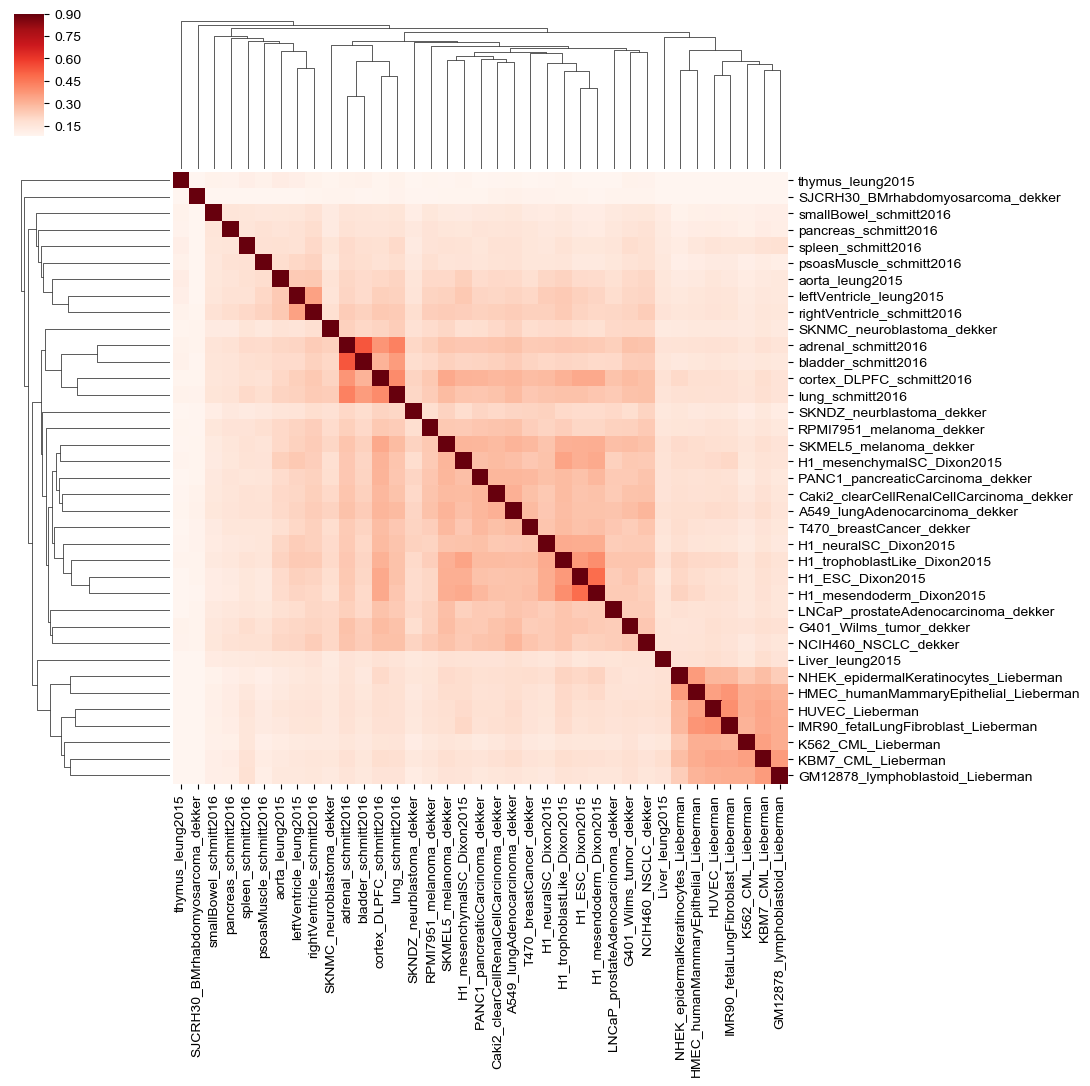

In [13]:
# using 40 kb boundaries
boundaries_tissueSpecific = binBoundaries(cell_type_tads,boundary_size = 40000, bin_size = 40000, centered = True, flatten = True, only_counts=False)
boundaries_tissueSpecific = boundaries_tissueSpecific.fillna(0)
boundariesBed = BedTool.from_dataframe(boundaries_tissueSpecific)
gap_regions = BedTool('/dors/capra_lab/users/evonne/resources/blacklist/gap_regions_hg19.bed').sort()
boundaries_intersectWithGaps = boundariesBed.intersect(gap_regions,wa=True).to_dataframe(disable_auto_names=False, header=None)
boundaries_intersectWithGaps.columns = boundaries_tissueSpecific.columns
boundaries_tissueSpecific_removeGapRegions = pd.merge(boundaries_tissueSpecific, boundaries_intersectWithGaps, how='outer', indicator=True)
boundaries_tissueSpecific_removeGapRegions = boundaries_tissueSpecific_removeGapRegions[boundaries_tissueSpecific_removeGapRegions['_merge'] == "left_only"]

res = pdist(boundaries_tissueSpecific.drop(['chr','loc','loc2'],axis=1).transpose(),'jaccard') # can also look at hamming
similarity = 1 - pd.DataFrame(squareform(res))

similarity.columns = boundaries_tissueSpecific.drop(['chr','loc','loc2'],axis=1).columns
similarity.index = boundaries_tissueSpecific.drop(['chr','loc','loc2'],axis=1).columns

linkage = hc.linkage(sp.distance.squareform(1 - similarity), method='complete')
g = sns.clustermap(similarity, cmap="Reds", vmin=0.08, vmax=.9, row_linkage=linkage, col_linkage=linkage)
g = plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0) # rotating the y-axis labels
#https://stackoverflow.com/questions/35639571/python-pandas-distance-matrix-using-jaccard-similarity
# https://stackoverflow.com/questions/38705359/how-to-give-sns-clustermap-a-precomputed-distance-matrix
#plt.savefig("/home/mcarthe/40kbSimilarityMatrix.pdf")


In [14]:
similarity[similarity!=1].melt().describe()
subset = similarity.loc[['GM12878_lymphoblastoid_Lieberman'],['HUVEC_Lieberman','IMR90_fetalLungFibroblast_Lieberman','K562_CML_Lieberman','HMEC_humanMammaryEpithelial_Lieberman','NHEK_epidermalKeratinocytes_Lieberman','KBM7_CML_Lieberman']]
subset.min().min()
subset.max().max()

,value
count,1332.000000
mean,0.190778
std,0.067712
min,0.051014
25%,0.150936
50%,0.179468
75%,0.232971
max,0.532509


0.23680144218387844

0.36609119079238606

### Suppl. 200 kb Bookend boundary definitions

In [164]:
boundaries_200kb = binBoundaries(cell_type_tads, boundary_size = 200000, bin_size = 200000, centered = False, flatten = True, only_counts=True)

# Remove overlap with genomic gap regions
boundariesBed = BedTool.from_dataframe(boundaries_200kb)
gap_regions = BedTool('/dors/capra_lab/users/evonne/resources/blacklist/gap_regions_hg19.bed').sort()
boundaries_intersectWithGaps = boundariesBed.intersect(gap_regions,wa=True).to_dataframe(disable_auto_names=False, header=None)
boundaries_intersectWithGaps.columns = ['chr','loc','loc2','counts'] 
boundaries_200kb_removeGapRegions = pd.merge(boundaries_200kb, boundaries_intersectWithGaps, how='outer', indicator=True)
boundaries_200kb_removeGapRegions = boundaries_200kb_removeGapRegions[boundaries_200kb_removeGapRegions['_merge'] == "left_only"][['chr','loc','loc2','counts']]
print("num boundaries removed bc of gap region overlap: ")
len(boundaries_200kb) - len(boundaries_200kb_removeGapRegions)
print("out of")
len(boundaries_200kb)
boundaries_200kb_removeGapRegions['stability_percentile'] = boundaries_200kb_removeGapRegions['counts'].rank(pct=True)
boundaries_200kb_removeGapRegions.to_csv("./data/200kbBookendBoundaries_byStability.bed",index=False, sep="\t")

num boundaries removed bc of gap region overlap: 


302

out of


10158

#### Suppl 200 kb stability histogram

,chr,loc,loc2,counts,stability_percentile
3,chr1,600000,800000,1.0,0.069856
4,chr1,1000000,1200000,3.0,0.251471
5,chr1,1200000,1400000,4.0,0.307275
6,chr1,1400000,1600000,8.0,0.476816
7,chr1,1600000,1800000,7.0,0.439478


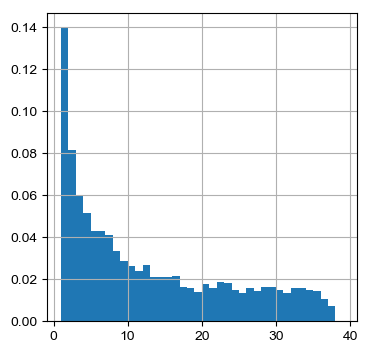

2.0

8.0

20.0

0.18313717532467533

0.1396103896103896

In [16]:
boundaries = boundaries_200kb_removeGapRegions
boundaries.head()
_ = boundaries['counts'].hist(bins=np.linspace(1,39,39), density=True, figsize=(4,4))
#plt.savefig("/home/mcarthe/200kbBoundaries_hist.pdf")
_ = plt.show()

max(boundaries[boundaries['stability_percentile'] < 0.25]['counts'])
max(boundaries[boundaries['stability_percentile'] < 0.5]['counts'])
max(boundaries[boundaries['stability_percentile'] < 0.75]['counts'])


len(boundaries[boundaries['counts'] >= 25])/len(boundaries)
len(boundaries[boundaries['counts'] == 1])/len(boundaries)

#### Separate by boundary stability

In [17]:
# Export
len(boundaries_200kb_removeGapRegions[(boundaries_200kb_removeGapRegions['stability_percentile'] > 0) & (boundaries_200kb_removeGapRegions['stability_percentile'] < 0.25)])
len(boundaries_200kb_removeGapRegions[(boundaries_200kb_removeGapRegions['stability_percentile'] > .25) & (boundaries_200kb_removeGapRegions['stability_percentile'] < 0.5)])
len(boundaries_200kb_removeGapRegions[(boundaries_200kb_removeGapRegions['stability_percentile'] > .5) & (boundaries_200kb_removeGapRegions['stability_percentile'] < 0.75)])
len(boundaries_200kb_removeGapRegions[(boundaries_200kb_removeGapRegions['stability_percentile'] > .75) & (boundaries_200kb_removeGapRegions['stability_percentile'] < 1)])
                                                                            
#boundaries_200kb_removeGapRegions[(boundaries_200kb_removeGapRegions['stability_percentile'] > 0) & (boundaries_200kb_removeGapRegions['stability_percentile'] < 0.25)][['chr','loc','loc2']].to_csv("Q1of4_200kbBookendBoundaries_removeGaps.bed",sep="\t",index=False, header=False)
#boundaries_200kb_removeGapRegions[(boundaries_200kb_removeGapRegions['stability_percentile'] > .25) & (boundaries_200kb_removeGapRegions['stability_percentile'] < 0.5)][['chr','loc','loc2']].to_csv("Q2of4_200kbBookendBoundaries_removeGaps.bed",sep="\t",index=False, header=False)
#boundaries_200kb_removeGapRegions[(boundaries_200kb_removeGapRegions['stability_percentile'] > .5) & (boundaries_200kb_removeGapRegions['stability_percentile'] < 0.75)][['chr','loc','loc2']].to_csv("Q3of4_200kbBookendBoundaries_removeGaps.bed",sep="\t",index=False, header=False)
#boundaries_200kb_removeGapRegions[(boundaries_200kb_removeGapRegions['stability_percentile'] > .75) & (boundaries_200kb_removeGapRegions['stability_percentile'] < 1)][['chr','loc','loc2']].to_csv("Q4of4_200kbBookendBoundaries_removeGaps.bed",sep="\t",index=False, header=False)

2181

2684

2521

2470

#### Suppl Fig. Jaccard similarity

/dors/capra_lab/users/evonne/resources/conda_envs/envs/evonne3/lib/python3.5/site-packages/pybedtools/bedtool.py:3433: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 40 fields; you can supply custom names with the `names` kwarg
  % (self.file_type, _names, self.field_count()))


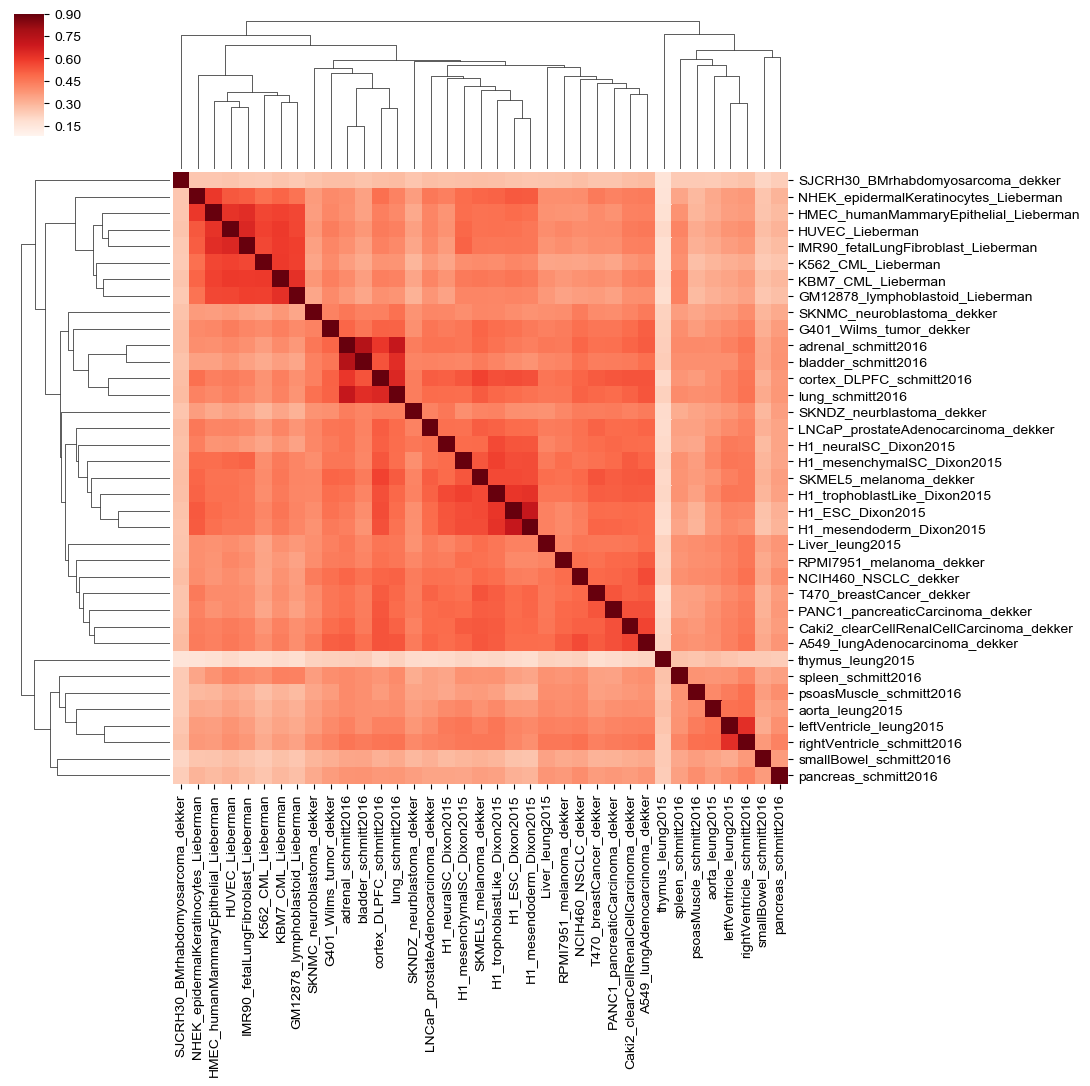

In [18]:
boundaries_tissueSpecific = binBoundaries(cell_type_tads,boundary_size = 200000, bin_size = 200000, centered = False, flatten = True, only_counts=False)
boundaries_tissueSpecific = boundaries_tissueSpecific.fillna(0)
boundariesBed = BedTool.from_dataframe(boundaries_tissueSpecific)
gap_regions = BedTool('/dors/capra_lab/users/evonne/resources/blacklist/gap_regions_hg19.bed').sort()
boundaries_intersectWithGaps = boundariesBed.intersect(gap_regions,wa=True).to_dataframe(disable_auto_names=False, header=None)
boundaries_intersectWithGaps.columns = boundaries_tissueSpecific.columns
boundaries_tissueSpecific_removeGapRegions = pd.merge(boundaries_tissueSpecific, boundaries_intersectWithGaps, how='outer', indicator=True)
boundaries_tissueSpecific_removeGapRegions = boundaries_tissueSpecific_removeGapRegions[boundaries_tissueSpecific_removeGapRegions['_merge'] == "left_only"]

res = pdist(boundaries_tissueSpecific.drop(['chr','loc','loc2'],axis=1).transpose(),'jaccard') # can also look at hamming
similarity = 1 - pd.DataFrame(squareform(res))

similarity.columns = boundaries_tissueSpecific.drop(['chr','loc','loc2'],axis=1).columns
similarity.index = boundaries_tissueSpecific.drop(['chr','loc','loc2'],axis=1).columns


linkage = hc.linkage(sp.distance.squareform(1 - similarity), method='complete')

g = sns.clustermap(similarity, cmap="Reds", vmin=0.08, vmax=0.9, row_linkage=linkage, col_linkage=linkage,)
g = plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0) # rotating the y-axis labels
#https://stackoverflow.com/questions/35639571/python-pandas-distance-matrix-using-jaccard-similarity
# https://stackoverflow.com/questions/38705359/how-to-give-sns-clustermap-a-precomputed-distance-matrix
#plt.savefig("/home/mcarthe/200kbSimilarityMatrix.pdf")


In [19]:
similarity[similarity!=1].melt().describe()
subset = similarity.loc[['GM12878_lymphoblastoid_Lieberman'],['HUVEC_Lieberman','IMR90_fetalLungFibroblast_Lieberman','K562_CML_Lieberman','HMEC_humanMammaryEpithelial_Lieberman','NHEK_epidermalKeratinocytes_Lieberman','KBM7_CML_Lieberman']]
subset.min().min()
subset.max().max()

,value
count,1332.000000
mean,0.405905
std,0.093714
min,0.164286
25%,0.351765
50%,0.408671
75%,0.465662
max,0.754006


0.4659372720641868

0.6230308758664147

## Boundary stability compared to functional annotations & heritability

### Fig. 3C Stability by Heritability

r2 =  0.04509217042486488 p = 0.006337275468540554


1    0.958252
2    1.052008
3    1.193452
4    1.066047
dtype: float64

1.1124906896080489

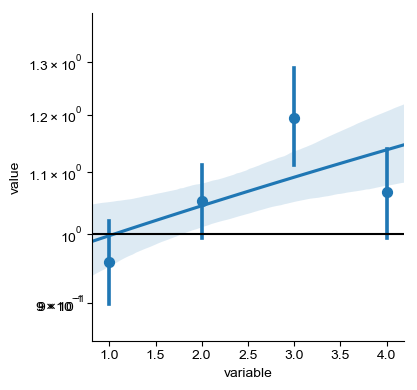

In [48]:
enr = partitioned_h2("boundaryStability","100kbBoundary_maintext").enr()
enr.columns = [1,2,3,4]
g = sns.lmplot(x='variable', y='value', data=enr.melt(), x_estimator=np.mean, height=4, aspect=1)
g.axes[0][0].axhline(y=1, color='black')
g.set(yscale="log")
g.set(ylim=(.85, 1.4))
g.set(yticks=[0.9, 1, 1.1, 1.2,1.3])
slope, intercept, r_value, p_value, std_err = stats.linregress(enr.melt()['variable'],enr.melt()['value'])
#plt.savefig("/home/mcarthe/100kbBoundaries_h2_all traits.pdf")
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))
enr.mean()
enr.mean()[4]/enr.mean()[1]

### Fig. 4D & F Stability by Heritability clustered

r2 =  0.22941256790405268 p = 2.350730229043741e-06


1    0.926493
2    1.141189
3    1.338217
4    1.234591
dtype: float64

1.3325418499453907

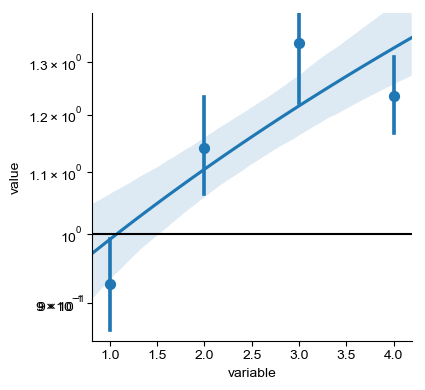

In [51]:
enr = partitioned_h2("boundaryStability","100kbBoundary_maintext").enr().loc[immuno_cluster]
enr.columns = [1,2,3,4]
g = sns.lmplot(x='variable', y='value', data=enr.melt(), x_estimator=np.mean, height=4, aspect=1)
g.axes[0][0].axhline(y=1, color='black')
g.set(yscale="log")
g.set(ylim=(.85, 1.4))
g.set(yticks=[0.9, 1, 1.1, 1.2,1.3])
slope, intercept, r_value, p_value, std_err = stats.linregress(enr.melt()['variable'],enr.melt()['value'])
#plt.savefig("/home/mcarthe/100kbBoundaries_h2_all traits.pdf")
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))
enr.mean()
enr.mean()[4]/enr.mean()[1]

r2 =  0.03830940762805553 p = 0.09017623903981763


1    0.995026
2    0.948746
3    1.025831
4    0.870891
dtype: float64

0.8752439388755968

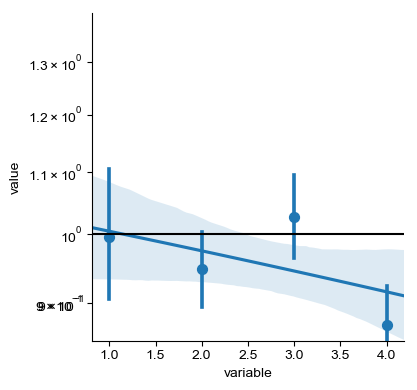

In [52]:
enr = partitioned_h2("boundaryStability","100kbBoundary_maintext").enr().loc[psych_cluster]
enr.columns = [1,2,3,4]
g = sns.lmplot(x='variable', y='value', data=enr.melt(), x_estimator=np.mean, height=4, aspect=1)
g.axes[0][0].axhline(y=1, color='black')
g.set(yscale="log")
g.set(ylim=(.85, 1.4))
g.set(yticks=[0.9, 1, 1.1, 1.2,1.3])
slope, intercept, r_value, p_value, std_err = stats.linregress(enr.melt()['variable'],enr.melt()['value'])
#plt.savefig("/home/mcarthe/100kbBoundaries_h2_all traits.pdf")
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))
enr.mean()
enr.mean()[4]/enr.mean()[1]

### Fig. 3D Conservation

In [257]:
boundaries_100kbBookend_removeGapRegions['stability_percentile_group'] = boundaries_100kbBookend_removeGapRegions['stability_percentile'].apply(stabilityPercentileToQuartile)
annotation = conservationQuantification(boundaries_100kbBookend_removeGapRegions, propBases=False, stability=True) # method above by Fig. 2B
annotation = annotation.reset_index()
annotation = annotation[annotation['original_boundary_stop'] - annotation['original_boundary_start'] == 100000]

r2 =  0.003727612678314019 p = 2.50408949715864e-13


r2 =  0.017342238729182495 p = 2.0451326854303645e-56


original_boundary_start       8.025916e+07
original_boundary_stop        8.035916e+07
stability_percentile_group    2.540328e+00
phastCons_score               3.353041e+02
numBases                      5.213324e+03
region_size                   1.000000e+05
Name: mean, dtype: float64

original_boundary_start       1.080754e+08
original_boundary_stop        1.080754e+08
stability_percentile_group    2.135699e+00
phastCons_score               5.422398e+01
numBases                      6.713811e+03
region_size                   0.000000e+00
Name: std, dtype: float64

,original_boundary_start,original_boundary_stop,phastCons_score,numBases,region_size
stability_percentile_group,,,,,
1,8.050675e+07,8.060675e+07,330.044911,4893.423290,100000.0
2,8.006081e+07,8.016081e+07,333.060843,5081.856825,100000.0
3,7.804317e+07,7.814317e+07,337.872469,5409.885103,100000.0
4,8.278753e+07,8.288753e+07,339.535621,5419.744266,100000.0


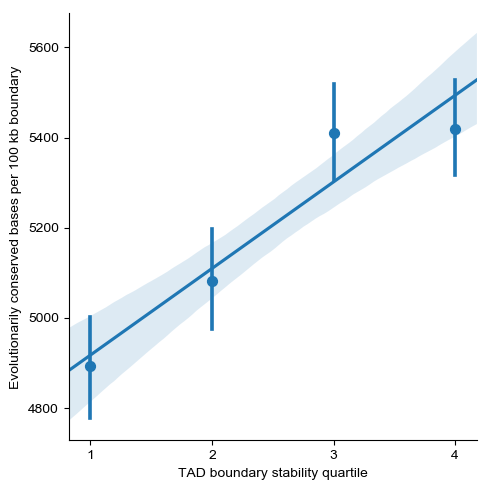

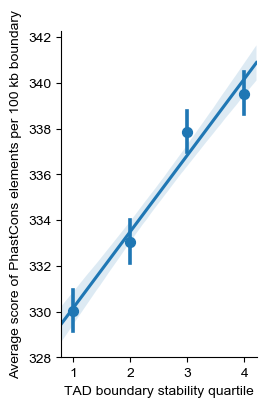

In [219]:
g = sns.lmplot(x='stability_percentile_group', y='numBases', data=annotation, x_estimator=np.mean)
g.set(xticks=[1,2,3,4],xlabel="TAD boundary stability quartile", ylabel="Evolutionarily conserved bases per 100 kb boundary")
slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['stability_percentile_group'],annotation['numBases'])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))
#plt.savefig("/home/mcarthe/100kbBoundaries_numConservedBP.pdf")

g = sns.lmplot(x='stability_percentile_group', y='phastCons_score', data=annotation, x_estimator=np.mean, height=4, aspect=.7)
g.set(xticks=[1,2,3,4],xlabel="TAD boundary stability quartile", ylabel="Average score of PhastCons elements per 100 kb boundary")
slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['stability_percentile_group'][~np.isnan(annotation['phastCons_score'])],annotation['phastCons_score'][~np.isnan(annotation['phastCons_score'])])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))
#plt.savefig("/home/mcarthe/100kbBoundaries_avgPhastConsScore.pdf")

annotation.describe().loc['mean']
1.96*(annotation.describe().loc['std'])# /np.sqrt(conserved_grouped.describe().loc['count']))

annotation.groupby(['stability_percentile_group']).mean()


### Fig. 3E CTCF

In [220]:
def annotationQuantification(regions, intersection):
        intersection = BedTool().from_dataframe(pd.read_csv(intersection, sep="\t", header=None).iloc[:,0:3])
        regions.columns = ['chr','start','stop'] + list(regions.columns)[3:]
        region_list = regions[['chr','start','stop', 'stability_percentile_group']]
        region_list.columns = ['chr','original_boundary_start','original_boundary_stop','stability_percentile_group']
        regions['original_boundary_start'] = regions['start']
        regions['original_boundary_stop'] = regions['stop']
        regions['region_size'] = regions['stop'] - regions['start']
        regions = regions.merge(regions.groupby(['chr', 'original_boundary_start','original_boundary_stop'],as_index=False).agg({'region_size': 'sum'}), on=['chr','original_boundary_start','original_boundary_stop'])#.reset_index()
        regions.drop('region_size_x',inplace=True,axis=1)
        regions = regions.rename(columns={'region_size_y':'region_size'})
        annotation = BedTool.from_dataframe(regions).intersect(intersection, wo=True).to_dataframe(disable_auto_names=True, header=None)
        
        annotation.columns = list(regions.columns) + ['elem_chr','elem_start','elem_stop','numBases']
        annotation['annot_count'] = 1

        annotation = region_list.merge(annotation, on=['chr','original_boundary_start','original_boundary_stop', 'stability_percentile_group'], how='outer')
        annotation_grouped = annotation.groupby(['chr', 'original_boundary_start','original_boundary_stop']).agg({'numBases': 'sum','annot_count':'sum','region_size':'mean', 'stability_percentile_group':'mean'})
        annotation_grouped['propBasesCovered'] = annotation_grouped['numBases']/annotation_grouped['region_size']
        annotation_grouped.loc[annotation_grouped['region_size'].isnull(),['numBases','annot_count','propBasesCovered']] = 0

        annotation_grouped = annotation_grouped.reset_index()
        return annotation_grouped


/dors/capra_lab/users/evonne/resources/conda_envs/envs/evonne3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


r2 =  0.025811162290403877 p = 1.482235648948294e-83


r2 =  0.029307220399601774 p = 8.835903791969268e-95


,original_boundary_start,original_boundary_stop,region_size,numBases,annot_count,propBasesCovered
stability_percentile_group,,,,,,
1,8.050675e+07,8.060675e+07,100000.0,2142.086260,3.985829,0.021421
2,8.006081e+07,8.016081e+07,100000.0,2813.721448,5.170752,0.028137
3,7.804317e+07,7.814317e+07,100000.0,3390.733648,6.061925,0.033907
4,8.278753e+07,8.288753e+07,100000.0,3455.419438,6.105791,0.034554


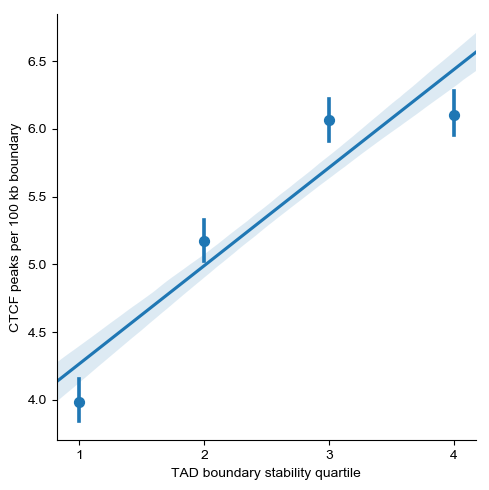

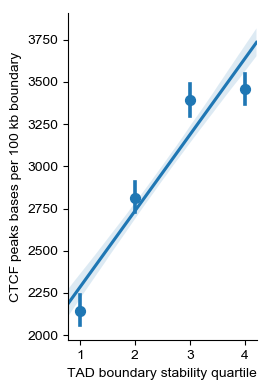

In [258]:
ctcf = '/dors/capra_lab/users/evonne/TAD/data/CTCF/ctcf_full_merged.bed'
annotation = annotationQuantification(boundaries_100kbBookend_removeGapRegions, ctcf)
annotation = annotation[annotation['original_boundary_stop'] - annotation['original_boundary_start'] == 100000]

g = sns.lmplot(x='stability_percentile_group', y='annot_count', data=annotation, x_estimator=np.mean)
g.set(xticks=[1,2,3,4],xlabel="TAD boundary stability quartile", ylabel="CTCF peaks per 100 kb boundary")

slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['stability_percentile_group'],annotation['annot_count'])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))
#plt.savefig("/home/mcarthe/100kbBoundaries_CTCFnumPeaks.pdf")

g = sns.lmplot(x='stability_percentile_group', y='numBases', data=annotation, x_estimator=np.mean, height=4, aspect=.7)
slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['stability_percentile_group'],annotation['numBases'])
g.set(xticks=[1,2,3,4],xlabel="TAD boundary stability quartile", ylabel="CTCF peaks bases per 100 kb boundary")
plt.savefig("/home/mcarthe/100kbBoundaries_CTCFnumBases.pdf")

print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))

annotation.groupby(['stability_percentile_group']).mean()

### Fig. 3F Housekeeping genes

/dors/capra_lab/users/evonne/resources/conda_envs/envs/evonne3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


r2 =  0.017752560274179856 p = 8.119819169918239e-58


,original_boundary_start,original_boundary_stop,region_size,numBases,annot_count,propBasesCovered
stability_percentile_group,,,,,,
1,8.050675e+07,8.060675e+07,100000.0,4216.018484,0.150339,0.042160
2,8.006081e+07,8.016081e+07,100000.0,5949.223398,0.224513,0.059492
3,7.804317e+07,7.814317e+07,100000.0,8166.814971,0.314350,0.081668
4,8.278753e+07,8.288753e+07,100000.0,9734.175172,0.374427,0.097342


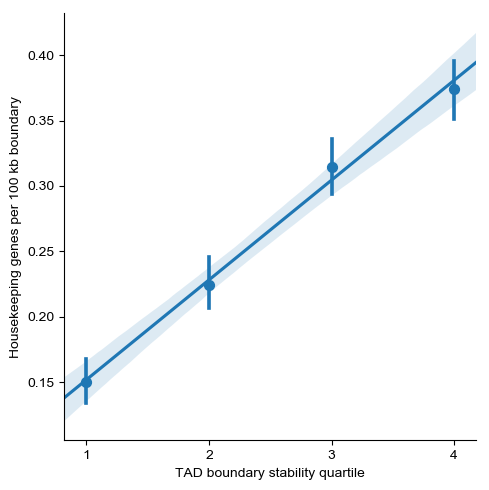

In [226]:
hkg = '/dors/capra_lab/users/evonne/TAD/paper/data/housekeeping_genes_coords.bed'
annotation = annotationQuantification(boundaries_100kbBookend_removeGapRegions, hkg)
annotation = annotation[annotation['original_boundary_stop'] - annotation['original_boundary_start'] == 100000]

g = sns.lmplot(x='stability_percentile_group', y='annot_count', data=annotation, x_estimator=np.mean)
g.set(xticks=[1,2,3,4],xlabel="TAD boundary stability quartile", ylabel="Housekeeping genes per 100 kb boundary")
slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['stability_percentile_group'],annotation['annot_count'])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))
annotation.groupby(['stability_percentile_group']).mean()
#plt.savefig("/home/mcarthe/100kbBoundaries_HKG.pdf")

#### Suppl all genes

/dors/capra_lab/users/evonne/resources/conda_envs/envs/evonne3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


r2 =  0.023049572148438793 p = 1.0276320674174134e-74


,original_boundary_start,original_boundary_stop,region_size,numBases,annot_count,propBasesCovered
stability_percentile_group,,,,,,
1,8.050675e+07,8.060675e+07,100000.0,45456.418053,1.324707,0.454564
2,8.006081e+07,8.016081e+07,100000.0,51775.470195,1.698886,0.517755
3,7.804317e+07,7.814317e+07,100000.0,55363.364835,2.018155,0.553634
4,8.278753e+07,8.288753e+07,100000.0,55485.381594,2.070814,0.554854


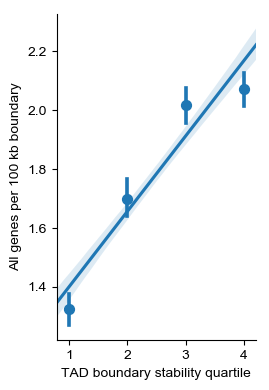

In [227]:
refseqgenes = '/dors/capra_lab/users/evonne/resources/refseq/refSeqGeneCoordinatesSimplified.bed'
annotation = annotationQuantification(boundaries_100kbBookend_removeGapRegions, refseqgenes)
annotation = annotation[annotation['original_boundary_stop'] - annotation['original_boundary_start'] == 100000]

g = sns.lmplot(x='stability_percentile_group', y='annot_count', data=annotation, x_estimator=np.mean, height=4, aspect=.7)
g.set(xticks=[1,2,3,4],xlabel="TAD boundary stability quartile", ylabel="All genes per 100 kb boundary")
slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['stability_percentile_group'],annotation['annot_count'])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))
annotation.groupby(['stability_percentile_group']).mean()
#plt.savefig("/home/mcarthe/100kbBoundaries_allGenes.pdf")

#### Suppl protein coding genes

/dors/capra_lab/users/evonne/resources/conda_envs/envs/evonne3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


r2 =  0.027781679807107218 p = 7.0595280430988315e-90


,original_boundary_start,original_boundary_stop,region_size,numBases,annot_count,propBasesCovered
stability_percentile_group,,,,,,
1,8.050675e+07,8.060675e+07,100000.0,39732.874923,0.998460,0.397329
2,8.006081e+07,8.016081e+07,100000.0,45387.644847,1.318106,0.453876
3,7.804317e+07,7.814317e+07,100000.0,49848.864710,1.603581,0.498489
4,8.278753e+07,8.288753e+07,100000.0,49945.849484,1.650516,0.499458


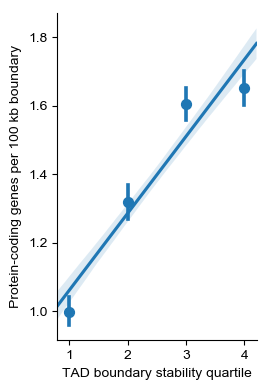

In [228]:
proteinCodingGenes = '/dors/capra_lab/users/evonne/resources/refseq/refSeqGeneCoordinatesSimplifiedProteinCoding.bed'
annotation = annotationQuantification(boundaries_100kbBookend_removeGapRegions, proteinCodingGenes)
annotation = annotation[annotation['original_boundary_stop'] - annotation['original_boundary_start'] == 100000]

g = sns.lmplot(x='stability_percentile_group', y='annot_count', data=annotation, x_estimator=np.mean, height=4, aspect=.7)
g.set(xticks=[1,2,3,4],xlabel="TAD boundary stability quartile", ylabel="Protein-coding genes per 100 kb boundary")
slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['stability_percentile_group'],annotation['annot_count'])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))
annotation.groupby(['stability_percentile_group']).mean()
#plt.savefig("/home/mcarthe/100kbBoundaries_proteinCodingGenes.pdf")

### Suppl 40 kb boundary stability by functional annotation

# HERITABILITY


r2 =  0.0015888553689406412 p = 0.6123233315496117


1    1.033382
2    1.044760
3    1.106825
4    1.055797
dtype: float64

1.0216910133131683

r2 =  0.04075779397083604 p = 0.05926155504589731


1    1.098054
2    1.007090
3    1.229344
4    1.255829
dtype: float64

1.1436864209826667

r2 =  0.0372514763445926 p = 0.09483007901847132


1    0.958499
2    1.088378
3    0.964960
4    0.824181
dtype: float64

0.8598664457095012

# CONSERVATION


/dors/capra_lab/users/evonne/resources/conda_envs/envs/evonne3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


r2 =  0.0026993542696401537 p = 2.3481401981848996e-15


r2 =  0.013950075802360086 p = 1.8649231175425622e-72


original_boundary_start       8.039010e+07
original_boundary_stop        8.043010e+07
stability_percentile_group    2.437783e+00
phastCons_score               3.345393e+02
numBases                      2.128038e+03
region_size                   4.000000e+04
Name: mean, dtype: float64

original_boundary_start       1.078763e+08
original_boundary_stop        1.078763e+08
stability_percentile_group    2.355632e+00
phastCons_score               7.026268e+01
numBases                      3.327030e+03
region_size                   0.000000e+00
Name: std, dtype: float64

,original_boundary_start,original_boundary_stop,phastCons_score,numBases,region_size
stability_percentile_group,,,,,
1,8.036759e+07,8.040759e+07,329.590155,2021.101423,40000.0
2,8.030322e+07,8.034322e+07,332.512556,2107.080381,40000.0
3,7.898371e+07,7.902371e+07,336.572538,2162.360289,40000.0
4,8.185225e+07,8.189225e+07,340.086014,2245.154088,40000.0


# CTCF


/dors/capra_lab/users/evonne/resources/conda_envs/envs/evonne3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


r2 =  0.023862865465563595 p = 5.976421857512369e-124


r2 =  0.028964587882555824 p = 2.08231741615114e-150


,original_boundary_start,original_boundary_stop,region_size,numBases,annot_count,propBasesCovered
stability_percentile_group,,,,,,
1,8.036759e+07,8.040759e+07,40000.0,998.771225,1.850407,0.024969
2,8.030322e+07,8.034322e+07,40000.0,1175.733849,2.149449,0.029393
3,7.898371e+07,7.902371e+07,40000.0,1372.176194,2.451244,0.034304
4,8.185225e+07,8.189225e+07,40000.0,1612.501821,2.789308,0.040313


# HKG


/dors/capra_lab/users/evonne/resources/conda_envs/envs/evonne3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


r2 =  0.017822229901458795 p = 8.692317441043933e-93


,original_boundary_start,original_boundary_stop,region_size,numBases,annot_count,propBasesCovered
stability_percentile_group,,,,,,
1,8.036759e+07,8.040759e+07,40000.0,2262.423996,0.113371,0.056561
2,8.030322e+07,8.034322e+07,40000.0,2489.540637,0.133968,0.062239
3,7.898371e+07,7.902371e+07,40000.0,3227.000672,0.189139,0.080675
4,8.185225e+07,8.189225e+07,40000.0,4534.414101,0.270937,0.113360


# ALL GENES


/dors/capra_lab/users/evonne/resources/conda_envs/envs/evonne3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


r2 =  0.0253253068365614 p = 1.6047545417442994e-131


,original_boundary_start,original_boundary_stop,region_size,numBases,annot_count,propBasesCovered
stability_percentile_group,,,,,,
1,8.036759e+07,8.040759e+07,40000.0,19001.008643,0.884342,0.475025
2,8.030322e+07,8.034322e+07,40000.0,20288.281929,1.036023,0.507207
3,7.898371e+07,7.902371e+07,40000.0,21544.591796,1.166274,0.538615
4,8.185225e+07,8.189225e+07,40000.0,22573.239325,1.321582,0.564331


# PROTEIN CODING


/dors/capra_lab/users/evonne/resources/conda_envs/envs/evonne3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


r2 =  0.02706954335581779 p = 1.450841901269909e-140


,original_boundary_start,original_boundary_stop,region_size,numBases,annot_count,propBasesCovered
stability_percentile_group,,,,,,
1,8.036759e+07,8.040759e+07,40000.0,16661.148322,0.716955,0.416529
2,8.030322e+07,8.034322e+07,40000.0,17895.615064,0.846085,0.447390
3,7.898371e+07,7.902371e+07,40000.0,19138.942165,0.955447,0.478474
4,8.185225e+07,8.189225e+07,40000.0,20342.999338,1.089209,0.508575


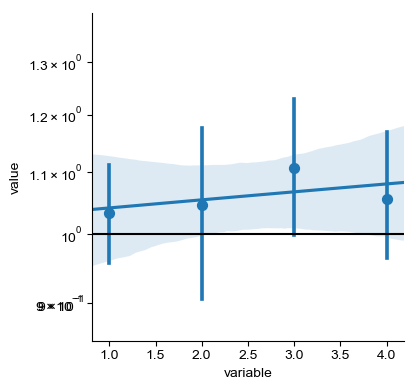

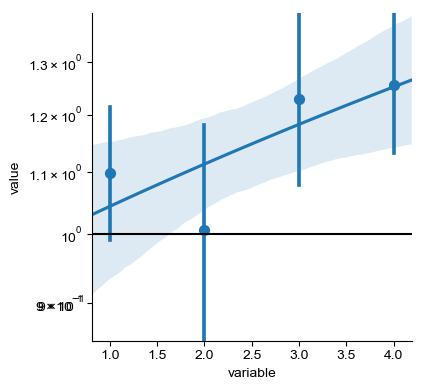

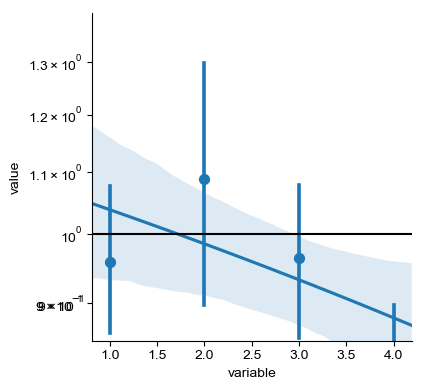

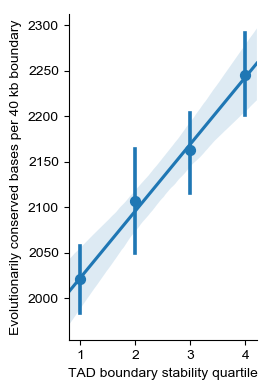

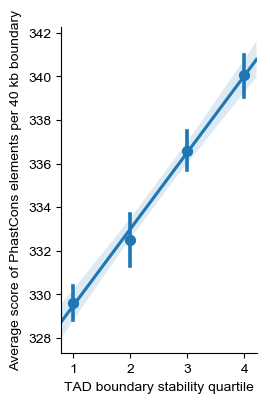

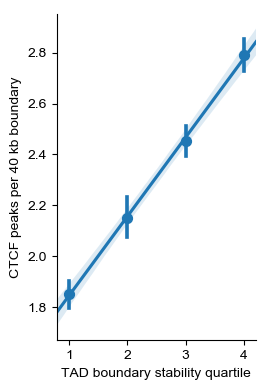

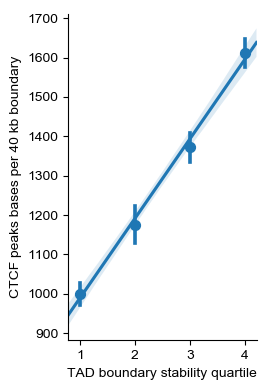

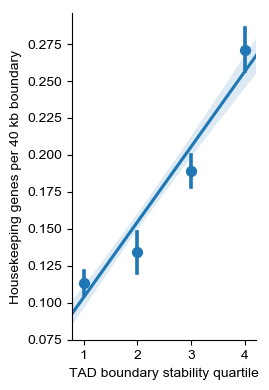

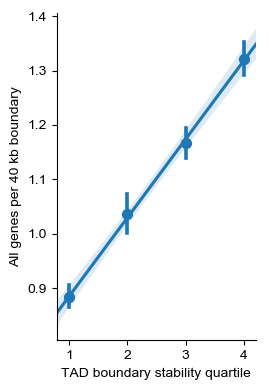

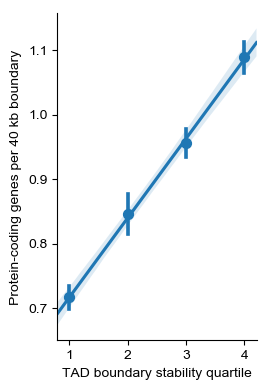

In [249]:
boundaries_40kb_removeGapRegions['stability_percentile_group'] = boundaries_40kb_removeGapRegions['stability_percentile'].apply(stabilityPercentileToQuartile)


# HERITABILITY
print("# HERITABILITY")
enr = partitioned_h2("boundaryStability","40kbBoundary_suppl").enr()
enr.columns = [1,2,3,4]
g = sns.lmplot(x='variable', y='value', data=enr.melt(), x_estimator=np.mean, height=4, aspect=1)
g.axes[0][0].axhline(y=1, color='black')
g.set(yscale="log")
g.set(ylim=(.85, 1.4))
g.set(yticks=[0.9, 1, 1.1, 1.2,1.3])
slope, intercept, r_value, p_value, std_err = stats.linregress(enr.melt()['variable'],enr.melt()['value'])
#plt.savefig("/home/mcarthe/40kbBoundaries_h2_all traits.pdf")
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))
enr.mean()
enr.mean()[4]/enr.mean()[1]

enr = partitioned_h2("boundaryStability","40kbBoundary_suppl").enr().loc[immuno_cluster]
enr.columns = [1,2,3,4]
g = sns.lmplot(x='variable', y='value', data=enr.melt(), x_estimator=np.mean, height=4, aspect=1)
g.axes[0][0].axhline(y=1, color='black')
g.set(yscale="log")
g.set(ylim=(.85, 1.4))
g.set(yticks=[0.9, 1, 1.1, 1.2,1.3])
slope, intercept, r_value, p_value, std_err = stats.linregress(enr.melt()['variable'],enr.melt()['value'])
#plt.savefig("/home/mcarthe/40kbBoundaries_h2_all traits.pdf")
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))
enr.mean()
enr.mean()[4]/enr.mean()[1]

enr = partitioned_h2("boundaryStability","40kbBoundary_suppl").enr().loc[psych_cluster]
enr.columns = [1,2,3,4]
g = sns.lmplot(x='variable', y='value', data=enr.melt(), x_estimator=np.mean, height=4, aspect=1)
g.axes[0][0].axhline(y=1, color='black')
g.set(yscale="log")
g.set(ylim=(.85, 1.4))
g.set(yticks=[0.9, 1, 1.1, 1.2,1.3])
slope, intercept, r_value, p_value, std_err = stats.linregress(enr.melt()['variable'],enr.melt()['value'])
#plt.savefig("/home/mcarthe/40kbBoundaries_h2_all traits.pdf")
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))
enr.mean()
enr.mean()[4]/enr.mean()[1]

# CONSERVATION
print("# CONSERVATION")
annotation = conservationQuantification(boundaries_40kb_removeGapRegions, propBases=False, stability=True) # method above by Fig. 2B
annotation = annotation.reset_index()
annotation = annotation[annotation['original_boundary_stop'] - annotation['original_boundary_start'] == 40000]
g = sns.lmplot(x='stability_percentile_group', y='numBases', data=annotation, x_estimator=np.mean, height=4, aspect=.7)
g.set(xticks=[1,2,3,4],xlabel="TAD boundary stability quartile", ylabel="Evolutionarily conserved bases per 40 kb boundary")
slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['stability_percentile_group'],annotation['numBases'])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))
#plt.savefig("/home/mcarthe/40kbBoundaries_numConservedBP.pdf")


g = sns.lmplot(x='stability_percentile_group', y='phastCons_score', data=annotation, x_estimator=np.mean, height=4, aspect=.7)
g.set(xticks=[1,2,3,4],xlabel="TAD boundary stability quartile", ylabel="Average score of PhastCons elements per 40 kb boundary")
slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['stability_percentile_group'][~np.isnan(annotation['phastCons_score'])],annotation['phastCons_score'][~np.isnan(annotation['phastCons_score'])])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))
#plt.savefig("/home/mcarthe/40kbBoundaries_avgPhastConsScore.pdf")

annotation.describe().loc['mean']
1.96*(annotation.describe().loc['std'])# /np.sqrt(conserved_grouped.describe().loc['count']))

annotation.groupby(['stability_percentile_group']).mean()

# CTCF
print("# CTCF")
ctcf = '/dors/capra_lab/users/evonne/TAD/data/CTCF/ctcf_full_merged.bed'
annotation = annotationQuantification(boundaries_40kb_removeGapRegions, ctcf)
annotation = annotation[annotation['original_boundary_stop'] - annotation['original_boundary_start'] == 40000]

g = sns.lmplot(x='stability_percentile_group', y='annot_count', data=annotation, x_estimator=np.mean, height=4, aspect=.7)
g.set(xticks=[1,2,3,4],xlabel="TAD boundary stability quartile", ylabel="CTCF peaks per 40 kb boundary")

slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['stability_percentile_group'],annotation['annot_count'])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))
#plt.savefig("/home/mcarthe/40kbBoundaries_CTCFnumPeaks.pdf")

g = sns.lmplot(x='stability_percentile_group', y='numBases', data=annotation, x_estimator=np.mean, height=4, aspect=.7)
slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['stability_percentile_group'],annotation['numBases'])
g.set(xticks=[1,2,3,4],xlabel="TAD boundary stability quartile", ylabel="CTCF peaks bases per 40 kb boundary")
plt.savefig("/home/mcarthe/40kbBoundaries_CTCFnumBases.pdf")

print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))

annotation.groupby(['stability_percentile_group']).mean()

# HOUSEKEEPING GENES
print("# HKG")
hkg = '/dors/capra_lab/users/evonne/TAD/paper/data/housekeeping_genes_coords.bed'
annotation = annotationQuantification(boundaries_40kb_removeGapRegions, hkg)
annotation = annotation[annotation['original_boundary_stop'] - annotation['original_boundary_start'] == 40000]

g = sns.lmplot(x='stability_percentile_group', y='annot_count', data=annotation, x_estimator=np.mean, height=4, aspect=.7)
g.set(xticks=[1,2,3,4],xlabel="TAD boundary stability quartile", ylabel="Housekeeping genes per 40 kb boundary")
slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['stability_percentile_group'],annotation['annot_count'])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))
annotation.groupby(['stability_percentile_group']).mean()
#plt.savefig("/home/mcarthe/40kbBoundaries_HKG.pdf")

# ALL GENES
print("# ALL GENES")
refseqgenes = '/dors/capra_lab/users/evonne/resources/refseq/refSeqGeneCoordinatesSimplified.bed'
annotation = annotationQuantification(boundaries_40kb_removeGapRegions, refseqgenes)
annotation = annotation[annotation['original_boundary_stop'] - annotation['original_boundary_start'] == 40000]

g = sns.lmplot(x='stability_percentile_group', y='annot_count', data=annotation, x_estimator=np.mean, height=4, aspect=.7)
g.set(xticks=[1,2,3,4],xlabel="TAD boundary stability quartile", ylabel="All genes per 40 kb boundary")
slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['stability_percentile_group'],annotation['annot_count'])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))
annotation.groupby(['stability_percentile_group']).mean()
#plt.savefig("/home/mcarthe/40kbBoundaries_allGenes.pdf")

# PROTEIN CODING GENES
print("# PROTEIN CODING")
proteinCodingGenes = '/dors/capra_lab/users/evonne/resources/refseq/refSeqGeneCoordinatesSimplifiedProteinCoding.bed'
annotation = annotationQuantification(boundaries_40kb_removeGapRegions, proteinCodingGenes)
annotation = annotation[annotation['original_boundary_stop'] - annotation['original_boundary_start'] == 40000]

g = sns.lmplot(x='stability_percentile_group', y='annot_count', data=annotation, x_estimator=np.mean, height=4, aspect=.7)
g.set(xticks=[1,2,3,4],xlabel="TAD boundary stability quartile", ylabel="Protein-coding genes per 40 kb boundary")
slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['stability_percentile_group'],annotation['annot_count'])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))
annotation.groupby(['stability_percentile_group']).mean()
#plt.savefig("/home/mcarthe/40kbBoundaries_proteinCodingGenes.pdf")



### Suppl 200 kb boundary stability by functional annotation

# HERITABILITY


r2 =  0.10894433375200137 p = 1.5875281581934537e-05


1    0.913547
2    1.080650
3    1.222118
4    1.095297
dtype: float64

1.1989488891171582

r2 =  0.4927871474018979 p = 2.5429451835702897e-14


1    0.780195
2    1.123029
3    1.348691
4    1.260252
dtype: float64

1.6153039049524058

r2 =  0.08620521346006799 p = 0.010047463236457716


1    1.067955
2    1.031580
3    1.075560
4    0.904295
dtype: float64

0.8467539526406787

# CONSERVATION


/dors/capra_lab/users/evonne/resources/conda_envs/envs/evonne3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


r2 =  0.003465228790514504 p = 4.9628654372064214e-09


r2 =  0.015542763163113357 p = 2.0326380190654247e-35


original_boundary_start       8.063364e+07
original_boundary_stop        8.083364e+07
stability_percentile_group    2.535714e+00
phastCons_score               3.350935e+02
numBases                      1.034011e+04
region_size                   2.000000e+05
Name: mean, dtype: float64

original_boundary_start       1.084449e+08
original_boundary_stop        1.084449e+08
stability_percentile_group    2.140474e+00
phastCons_score               4.473099e+01
numBases                      1.168961e+04
region_size                   0.000000e+00
Name: std, dtype: float64

,original_boundary_start,original_boundary_stop,phastCons_score,numBases,region_size
stability_percentile_group,,,,,
1,8.148547e+07,8.168547e+07,329.637109,9681.726731,200000.0
2,7.877250e+07,7.897250e+07,335.043514,10288.092027,200000.0
3,7.883689e+07,7.903689e+07,337.219306,10660.834986,200000.0
4,8.373773e+07,8.393773e+07,337.796036,10650.643320,200000.0


# CTCF


/dors/capra_lab/users/evonne/resources/conda_envs/envs/evonne3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


r2 =  0.0318605268669431 p = 2.3352684230289115e-71


r2 =  0.03527814243617348 p = 6.017421684617653e-79


,original_boundary_start,original_boundary_stop,region_size,numBases,annot_count,propBasesCovered
stability_percentile_group,,,,,,
1,8.148547e+07,8.168547e+07,200000.0,3536.236130,6.734525,0.017681
2,7.877250e+07,7.897250e+07,200000.0,5704.626677,10.428465,0.028523
3,7.883689e+07,7.903689e+07,200000.0,6355.706069,11.460532,0.031779
4,8.373773e+07,8.393773e+07,200000.0,6229.814980,11.188259,0.031149


# HKG


/dors/capra_lab/users/evonne/resources/conda_envs/envs/evonne3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


r2 =  0.018736591691594532 p = 1.9686623335973092e-42


,original_boundary_start,original_boundary_stop,region_size,numBases,annot_count,propBasesCovered
stability_percentile_group,,,,,,
1,8.148547e+07,8.168547e+07,200000.0,7925.328748,0.198533,0.039627
2,7.877250e+07,7.897250e+07,200000.0,12633.686289,0.381893,0.063168
3,7.883689e+07,7.903689e+07,200000.0,15666.008330,0.480365,0.078330
4,8.373773e+07,8.393773e+07,200000.0,16530.012146,0.520648,0.082650


# ALL GENES


/dors/capra_lab/users/evonne/resources/conda_envs/envs/evonne3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


r2 =  0.02526710564690112 p = 8.742252862196221e-57


,original_boundary_start,original_boundary_stop,region_size,numBases,annot_count,propBasesCovered
stability_percentile_group,,,,,,
1,8.148547e+07,8.168547e+07,200000.0,86797.286107,1.808803,0.433986
2,7.877250e+07,7.897250e+07,200000.0,105623.181818,2.907228,0.528116
3,7.883689e+07,7.903689e+07,200000.0,109292.047600,3.182467,0.546460
4,8.373773e+07,8.393773e+07,200000.0,111280.217004,3.152227,0.556401


# PROTEIN CODING


/dors/capra_lab/users/evonne/resources/conda_envs/envs/evonne3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


r2 =  0.028790238532178273 p = 1.4634174479658854e-64


,original_boundary_start,original_boundary_stop,region_size,numBases,annot_count,propBasesCovered
stability_percentile_group,,,,,,
1,8.148547e+07,8.168547e+07,200000.0,73939.098120,1.300321,0.369695
2,7.877250e+07,7.897250e+07,200000.0,94625.352459,2.209016,0.473127
3,7.883689e+07,7.903689e+07,200000.0,98760.978580,2.468465,0.493805
4,8.373773e+07,8.393773e+07,200000.0,99441.953846,2.435628,0.497210


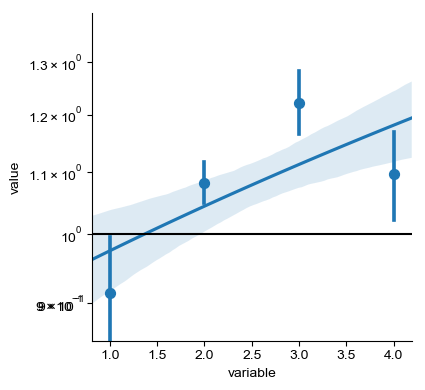

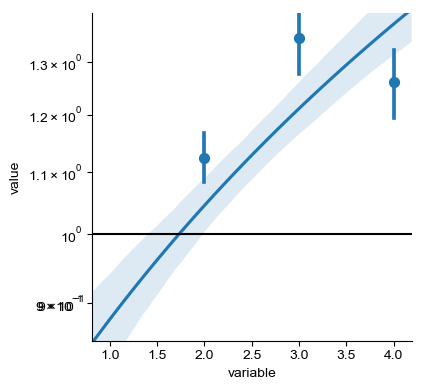

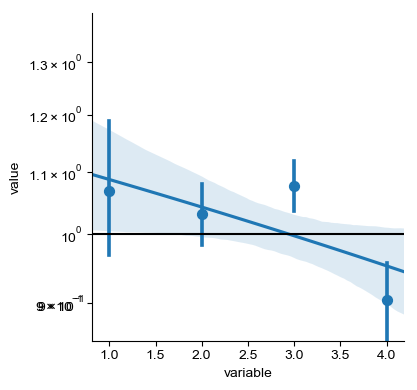

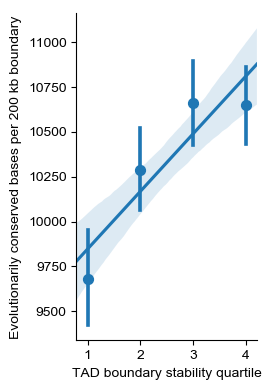

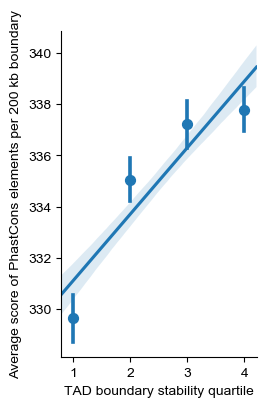

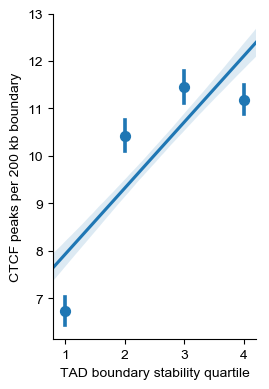

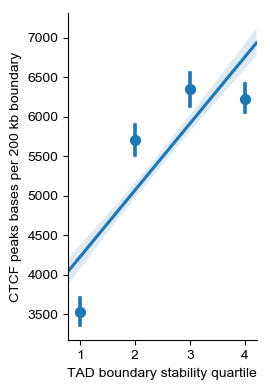

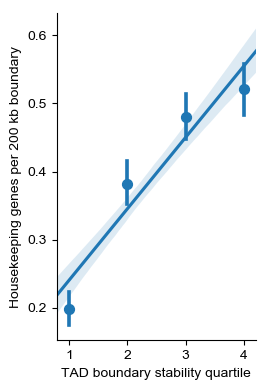

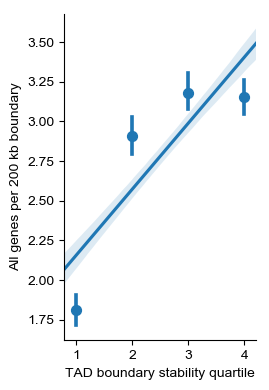

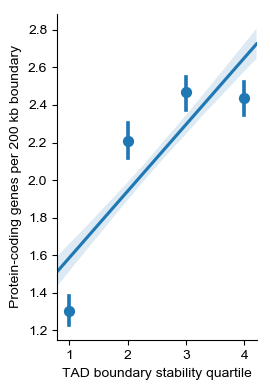

In [250]:
boundaries_200kb_removeGapRegions['stability_percentile_group'] = boundaries_200kb_removeGapRegions['stability_percentile'].apply(stabilityPercentileToQuartile)


# HERITABILITY
print("# HERITABILITY")
enr = partitioned_h2("boundaryStability","200kbBoundary_suppl").enr()
enr.columns = [1,2,3,4]
g = sns.lmplot(x='variable', y='value', data=enr.melt(), x_estimator=np.mean, height=4, aspect=1)
g.axes[0][0].axhline(y=1, color='black')
g.set(yscale="log")
g.set(ylim=(.85, 1.4))
g.set(yticks=[0.9, 1, 1.1, 1.2,1.3])
slope, intercept, r_value, p_value, std_err = stats.linregress(enr.melt()['variable'],enr.melt()['value'])
#plt.savefig("/home/mcarthe/200kbBoundaries_h2_all traits.pdf")
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))
enr.mean()
enr.mean()[4]/enr.mean()[1]

enr = partitioned_h2("boundaryStability","200kbBoundary_suppl").enr().loc[immuno_cluster]
enr.columns = [1,2,3,4]
g = sns.lmplot(x='variable', y='value', data=enr.melt(), x_estimator=np.mean, height=4, aspect=1)
g.axes[0][0].axhline(y=1, color='black')
g.set(yscale="log")
g.set(ylim=(.85, 1.4))
g.set(yticks=[0.9, 1, 1.1, 1.2,1.3])
slope, intercept, r_value, p_value, std_err = stats.linregress(enr.melt()['variable'],enr.melt()['value'])
#plt.savefig("/home/mcarthe/200kbBoundaries_h2_all traits.pdf")
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))
enr.mean()
enr.mean()[4]/enr.mean()[1]

enr = partitioned_h2("boundaryStability","200kbBoundary_suppl").enr().loc[psych_cluster]
enr.columns = [1,2,3,4]
g = sns.lmplot(x='variable', y='value', data=enr.melt(), x_estimator=np.mean, height=4, aspect=1)
g.axes[0][0].axhline(y=1, color='black')
g.set(yscale="log")
g.set(ylim=(.85, 1.4))
g.set(yticks=[0.9, 1, 1.1, 1.2,1.3])
slope, intercept, r_value, p_value, std_err = stats.linregress(enr.melt()['variable'],enr.melt()['value'])
#plt.savefig("/home/mcarthe/200kbBoundaries_h2_all traits.pdf")
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))
enr.mean()
enr.mean()[4]/enr.mean()[1]

# CONSERVATION
print("# CONSERVATION")
annotation = conservationQuantification(boundaries_200kb_removeGapRegions, propBases=False, stability=True) # method above by Fig. 2B
annotation = annotation.reset_index()
annotation = annotation[annotation['original_boundary_stop'] - annotation['original_boundary_start'] == 200000]
g = sns.lmplot(x='stability_percentile_group', y='numBases', data=annotation, x_estimator=np.mean, height=4, aspect=.7)
g.set(xticks=[1,2,3,4],xlabel="TAD boundary stability quartile", ylabel="Evolutionarily conserved bases per 200 kb boundary")
slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['stability_percentile_group'],annotation['numBases'])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))
#plt.savefig("/home/mcarthe/200kbBoundaries_numConservedBP.pdf")

g = sns.lmplot(x='stability_percentile_group', y='phastCons_score', data=annotation, x_estimator=np.mean, height=4, aspect=.7)
g.set(xticks=[1,2,3,4],xlabel="TAD boundary stability quartile", ylabel="Average score of PhastCons elements per 200 kb boundary")
slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['stability_percentile_group'][~np.isnan(annotation['phastCons_score'])],annotation['phastCons_score'][~np.isnan(annotation['phastCons_score'])])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))
#plt.savefig("/home/mcarthe/200kbBoundaries_avgPhastConsScore.pdf")

annotation.describe().loc['mean']
1.96*(annotation.describe().loc['std'])# /np.sqrt(conserved_grouped.describe().loc['count']))

annotation.groupby(['stability_percentile_group']).mean()

# CTCF
print("# CTCF")
ctcf = '/dors/capra_lab/users/evonne/TAD/data/CTCF/ctcf_full_merged.bed'
annotation = annotationQuantification(boundaries_200kb_removeGapRegions, ctcf)
annotation = annotation[annotation['original_boundary_stop'] - annotation['original_boundary_start'] == 200000]

g = sns.lmplot(x='stability_percentile_group', y='annot_count', data=annotation, x_estimator=np.mean,height=4, aspect=.7)
g.set(xticks=[1,2,3,4],xlabel="TAD boundary stability quartile", ylabel="CTCF peaks per 200 kb boundary")

slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['stability_percentile_group'],annotation['annot_count'])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))
#plt.savefig("/home/mcarthe/200kbBoundaries_CTCFnumPeaks.pdf")

g = sns.lmplot(x='stability_percentile_group', y='numBases', data=annotation, x_estimator=np.mean, height=4, aspect=.7)
slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['stability_percentile_group'],annotation['numBases'])
g.set(xticks=[1,2,3,4],xlabel="TAD boundary stability quartile", ylabel="CTCF peaks bases per 200 kb boundary")
plt.savefig("/home/mcarthe/200kbBoundaries_CTCFnumBases.pdf")

print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))

annotation.groupby(['stability_percentile_group']).mean()

# HOUSEKEEPING GENES
print("# HKG")
hkg = '/dors/capra_lab/users/evonne/TAD/paper/data/housekeeping_genes_coords.bed'
annotation = annotationQuantification(boundaries_200kb_removeGapRegions, hkg)
annotation = annotation[annotation['original_boundary_stop'] - annotation['original_boundary_start'] == 200000]

g = sns.lmplot(x='stability_percentile_group', y='annot_count', data=annotation, x_estimator=np.mean, height=4, aspect=.7)
g.set(xticks=[1,2,3,4],xlabel="TAD boundary stability quartile", ylabel="Housekeeping genes per 200 kb boundary")
slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['stability_percentile_group'],annotation['annot_count'])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))
annotation.groupby(['stability_percentile_group']).mean()
#plt.savefig("/home/mcarthe/200kbBoundaries_HKG.pdf")

# ALL GENES
print("# ALL GENES")
refseqgenes = '/dors/capra_lab/users/evonne/resources/refseq/refSeqGeneCoordinatesSimplified.bed'
annotation = annotationQuantification(boundaries_200kb_removeGapRegions, refseqgenes)
annotation = annotation[annotation['original_boundary_stop'] - annotation['original_boundary_start'] == 200000]

g = sns.lmplot(x='stability_percentile_group', y='annot_count', data=annotation, x_estimator=np.mean, height=4, aspect=.7)
g.set(xticks=[1,2,3,4],xlabel="TAD boundary stability quartile", ylabel="All genes per 200 kb boundary")
slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['stability_percentile_group'],annotation['annot_count'])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))
annotation.groupby(['stability_percentile_group']).mean()
#plt.savefig("/home/mcarthe/200kbBoundaries_allGenes.pdf")

# PROTEIN CODING GENES
print("# PROTEIN CODING")
proteinCodingGenes = '/dors/capra_lab/users/evonne/resources/refseq/refSeqGeneCoordinatesSimplifiedProteinCoding.bed'
annotation = annotationQuantification(boundaries_200kb_removeGapRegions, proteinCodingGenes)
annotation = annotation[annotation['original_boundary_stop'] - annotation['original_boundary_start'] == 200000]

g = sns.lmplot(x='stability_percentile_group', y='annot_count', data=annotation, x_estimator=np.mean, height=4, aspect=.7)
g.set(xticks=[1,2,3,4],xlabel="TAD boundary stability quartile", ylabel="Protein-coding genes per 200 kb boundary")
slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['stability_percentile_group'],annotation['annot_count'])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))
annotation.groupby(['stability_percentile_group']).mean()
#plt.savefig("/home/mcarthe/200kbBoundaries_proteinCodingGenes.pdf")



## Suppl Germ layer stability

In [251]:
germ_layers = {}
germ_layers['endoderm'] = ["A549_lungAdenocarcinoma_dekker",
"adrenal_schmitt2016",
"bladder_schmitt2016",
"IMR90_fetalLungFibroblast_Lieberman",
"Liver_leung2015",
"LNCaP_prostateAdenocarcinoma_dekker",
"lung_schmitt2016",
"NCIH460_NSCLC_dekker",
"PANC1_pancreaticCarcinoma_dekker",
"pancreas_schmitt2016",
"smallBowel_schmitt2016",
"thymus_leung2015"]

germ_layers['ectoderm'] = ["cortex_DLPFC_schmitt2016",
"H1_neuralSC_Dixon2015",
"HMEC_humanMammaryEpithelial_Lieberman",
"NHEK_epidermalKeratinocytes_Lieberman",
"RPMI7951_melanoma_dekker",
"SKMEL5_melanoma_dekker",
"SKNDZ_neurblastoma_dekker",
"SKNMC_neuroblastoma_dekker",
"T470_breastCancer_dekker"]

germ_layers['mesoderm'] = ["aorta_leung2015",
"Caki2_clearCellRenalCellCarcinoma_dekker",
"G401_Wilms_tumor_dekker",
"GM12878_lymphoblastoid_Lieberman",
"H1_mesenchymalSC_Dixon2015",
"HUVEC_Lieberman",
"K562_CML_Lieberman",
"KBM7_CML_Lieberman",
"leftVentricle_leung2015",
"psoasMuscle_schmitt2016",
"rightVentricle_schmitt2016",
"SJCRH30_BMrhabdomyosarcoma_dekker",
"spleen_schmitt2016"]

len(germ_layers['endoderm'])
len(germ_layers['ectoderm'])
len(germ_layers['mesoderm'])

12

9

13

In [252]:
boundaries_100kbBookend = binBoundaries(cell_type_tads, boundary_size = 100000, bin_size = 100000, centered = False, flatten = True, only_counts=False)
boundariesBed = BedTool.from_dataframe(boundaries_100kbBookend[['chr','loc','loc2']])
len(boundaries_100kbBookend)
gap_regions = BedTool('/dors/capra_lab/users/evonne/resources/blacklist/gap_regions_hg19.bed').sort()
boundaries_intersectWithGaps = boundariesBed.intersect(gap_regions,wa=True).to_dataframe(disable_auto_names=False, header=None)
boundaries_intersectWithGaps.columns = ['chr','loc','loc2'] 
boundaries_100kbBookend = pd.merge(boundaries_100kbBookend, boundaries_intersectWithGaps, how='outer', indicator=True)
boundaries_100kbBookend = boundaries_100kbBookend[boundaries_100kbBookend['_merge'] == "left_only"]#[['chr','loc','loc2','counts']]
len(boundaries_100kbBookend)

boundaries_100kbBookend['endoderm_count'] = boundaries_100kbBookend.loc[:,germ_layers['endoderm']].sum(axis=1)
boundaries_100kbBookend['ectoderm_count'] = boundaries_100kbBookend.loc[:,germ_layers['ectoderm']].sum(axis=1)
boundaries_100kbBookend['mesoderm_count'] = boundaries_100kbBookend.loc[:,germ_layers['mesoderm']].sum(axis=1)

14654

14345

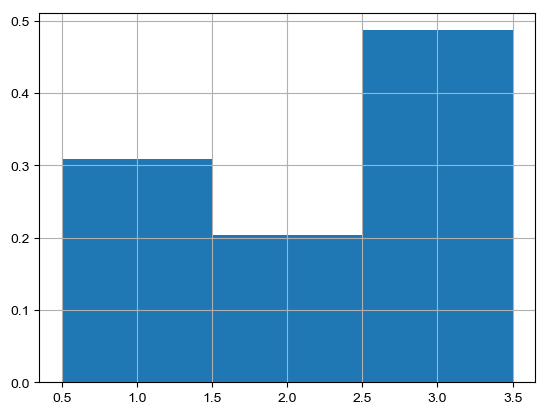

In [253]:

boundaries_100kbBookend['stability'] = 0
boundaries_100kbBookend.loc[(boundaries_100kbBookend['endoderm_count'] > 0) & (boundaries_100kbBookend['ectoderm_count'] > 0) & (boundaries_100kbBookend['mesoderm_count'] > 0),'stability'] = 3
boundaries_100kbBookend.loc[(boundaries_100kbBookend['endoderm_count'] == 0) | (boundaries_100kbBookend['ectoderm_count'] == 0) | (boundaries_100kbBookend['mesoderm_count'] == 0),'stability'] = 2
boundaries_100kbBookend.loc[((boundaries_100kbBookend['endoderm_count'] == 0) & (boundaries_100kbBookend['ectoderm_count'] == 0)) | ((boundaries_100kbBookend['endoderm_count'] == 0) & (boundaries_100kbBookend['mesoderm_count'] == 0)) | ((boundaries_100kbBookend['mesoderm_count'] == 0) & (boundaries_100kbBookend['ectoderm_count'] == 0)),'stability'] = 1

boundaries_100kbBookend['stability'].hist(bins=[0.5,1.5,2.5,3.5],density=True)

#plt.savefig("/home/mcarthe/germLayer_hist.pdf")

# Export
#for i in [1,2,3]:
#    boundaries_100kbBookend[boundaries_100kbBookend['stability'] == i][['chr','loc','loc2']].to_csv("boundaries_100kbBookend_germLayerStability_%s.bed" % i, header=False, index=False, sep="\t")

# HERITABILITY


/dors/capra_lab/users/evonne/resources/conda_envs/envs/evonne3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


r2 =  0.07510781727115211 p = 0.0021595275993308034


1    0.979355
2    1.073174
3    1.137032
dtype: float64

1.1610011060842989

r2 =  0.2506291402908789 p = 1.8623388114141575e-05


1    0.972763
2    1.175267
3    1.295205
dtype: float64

1.331470974684656

r2 =  0.008643818659142013 p = 0.49153747142049264


1    0.986988
2    0.954962
3    0.953884
dtype: float64

0.9664597678300788

# CONSERVATION


/dors/capra_lab/users/evonne/resources/conda_envs/envs/evonne3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


r2 =  0.004063792298653355 p = 2.1348993485268076e-14


r2 =  0.017613489043502583 p = 2.812078579065394e-57


original_boundary_start       8.025916e+07
original_boundary_stop        8.035916e+07
stability_percentile_group    2.178111e+00
phastCons_score               3.353041e+02
numBases                      5.213324e+03
region_size                   1.000000e+05
Name: mean, dtype: float64

original_boundary_start       1.080754e+08
original_boundary_stop        1.080754e+08
stability_percentile_group    1.713422e+00
phastCons_score               5.422398e+01
numBases                      6.713811e+03
region_size                   0.000000e+00
Name: std, dtype: float64

,original_boundary_start,original_boundary_stop,phastCons_score,numBases,region_size
stability_percentile_group,,,,,
1,8.059957e+07,8.069957e+07,330.635185,4923.051907,100000.0
2,8.007900e+07,8.017900e+07,333.709974,5156.712432,100000.0
3,8.011877e+07,8.021877e+07,338.932183,5421.161895,100000.0


# CTCF


/dors/capra_lab/users/evonne/resources/conda_envs/envs/evonne3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


r2 =  0.0300961159624876 p = 2.56004888266805e-97


r2 =  0.03347879140827411 p = 3.1902818779164096e-108


,original_boundary_start,original_boundary_stop,region_size,numBases,annot_count,propBasesCovered
stability_percentile_group,,,,,,
1,8.059957e+07,8.069957e+07,100000.0,2265.806364,4.210562,0.022658
2,8.007900e+07,8.017900e+07,100000.0,2887.093921,5.269809,0.028871
3,8.011877e+07,8.021877e+07,100000.0,3470.929860,6.167478,0.034709


# HKG


/dors/capra_lab/users/evonne/resources/conda_envs/envs/evonne3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


r2 =  0.01791221270548605 p = 2.5196763766989942e-58


,original_boundary_start,original_boundary_stop,region_size,numBases,annot_count,propBasesCovered
stability_percentile_group,,,,,,
1,8.059957e+07,8.069957e+07,100000.0,4436.198149,0.160009,0.044362
2,8.007900e+07,8.017900e+07,100000.0,6428.584699,0.242486,0.064286
3,8.011877e+07,8.021877e+07,100000.0,9068.821071,0.349986,0.090688


# ALL GENES


/dors/capra_lab/users/evonne/resources/conda_envs/envs/evonne3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


r2 =  0.02507653680896983 p = 3.3489759727317475e-81


,original_boundary_start,original_boundary_stop,region_size,numBases,annot_count,propBasesCovered
stability_percentile_group,,,,,,
1,8.059957e+07,8.069957e+07,100000.0,46856.989619,1.402167,0.468570
2,8.007900e+07,8.017900e+07,100000.0,51468.603484,1.735997,0.514686
3,8.011877e+07,8.021877e+07,100000.0,56005.035786,2.067134,0.560050


# PROTEIN CODING


/dors/capra_lab/users/evonne/resources/conda_envs/envs/evonne3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


r2 =  0.03154264861245665 p = 5.6175334514483216e-102


,original_boundary_start,original_boundary_stop,region_size,numBases,annot_count,propBasesCovered
stability_percentile_group,,,,,,
1,8.059957e+07,8.069957e+07,100000.0,40933.119838,1.057549,0.409331
2,8.007900e+07,8.017900e+07,100000.0,45373.794740,1.348361,0.453738
3,8.011877e+07,8.021877e+07,100000.0,50434.989980,1.652448,0.504350


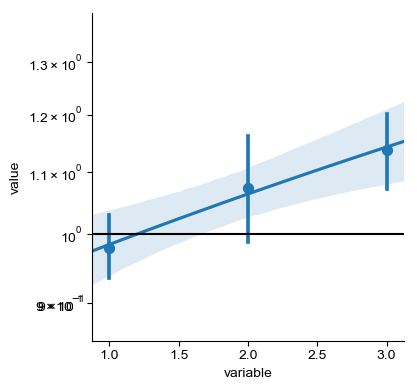

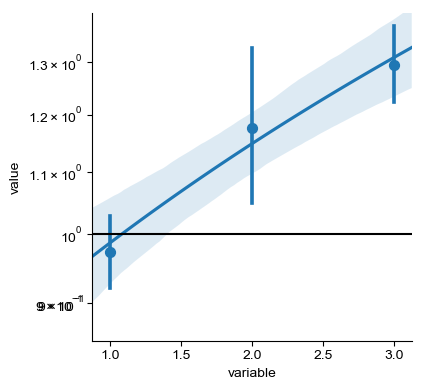

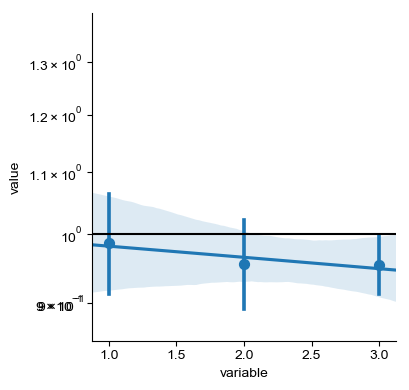

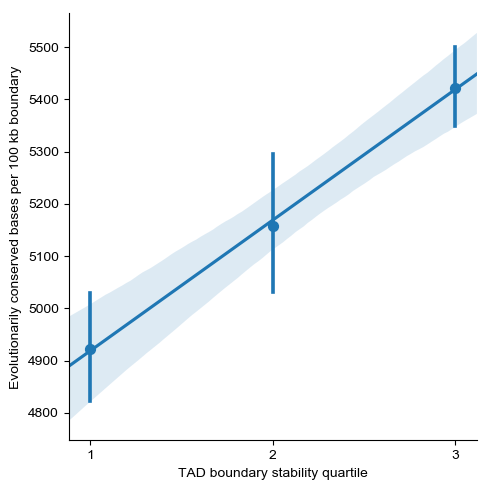

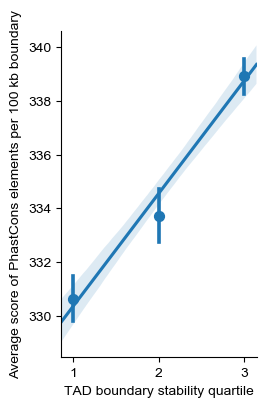

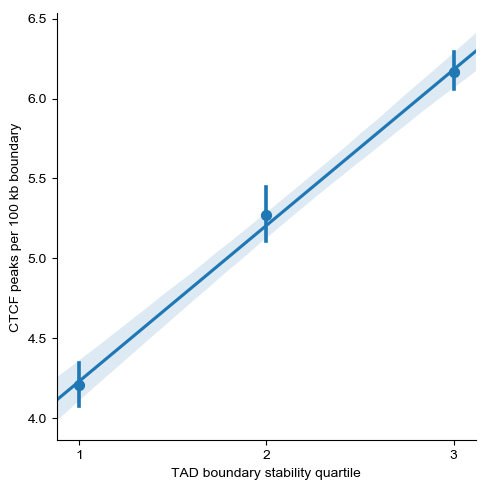

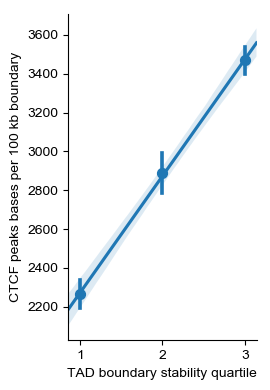

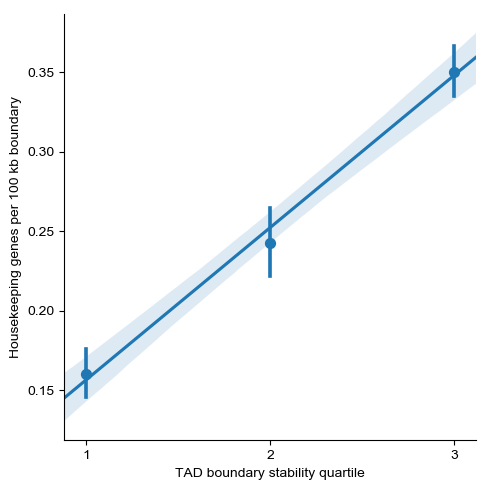

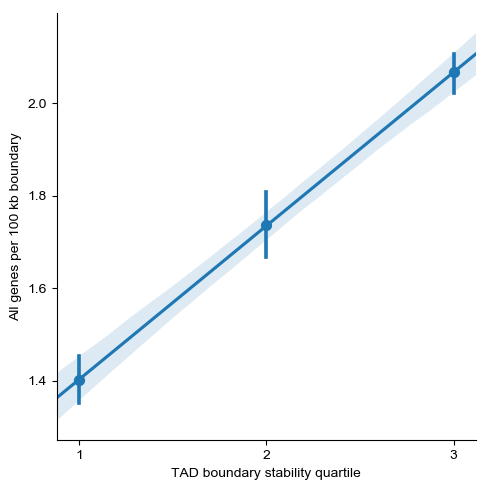

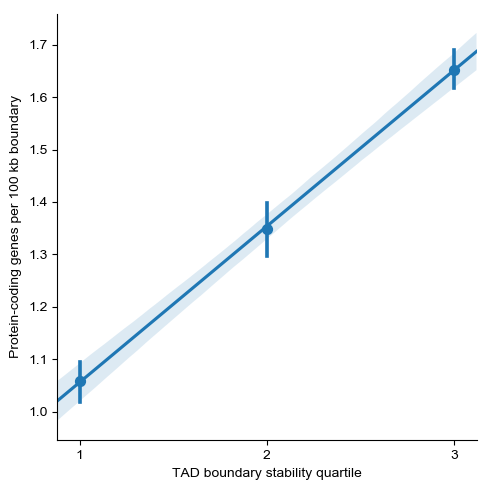

In [254]:
boundaries_100kbBookend['stability_percentile_group'] = boundaries_100kbBookend['stability']


# HERITABILITY
print("# HERITABILITY")
enr = partitioned_h2("boundaryStability","germLayer_suppl").enr()
enr.columns = [1,2,3]
g = sns.lmplot(x='variable', y='value', data=enr.melt(), x_estimator=np.mean, height=4, aspect=1)
g.axes[0][0].axhline(y=1, color='black')
g.set(yscale="log")
g.set(ylim=(.85, 1.4))
g.set(yticks=[0.9, 1, 1.1, 1.2,1.3])
slope, intercept, r_value, p_value, std_err = stats.linregress(enr.melt()['variable'],enr.melt()['value'])
#plt.savefig("/home/mcarthe/germLayer_h2_all traits.pdf")
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))
enr.mean()
enr.mean()[3]/enr.mean()[1]

enr = partitioned_h2("boundaryStability","germLayer_suppl").enr().loc[immuno_cluster]
enr.columns = [1,2,3]
g = sns.lmplot(x='variable', y='value', data=enr.melt(), x_estimator=np.mean, height=4, aspect=1)
g.axes[0][0].axhline(y=1, color='black')
g.set(yscale="log")
g.set(ylim=(.85, 1.4))
g.set(yticks=[0.9, 1, 1.1, 1.2,1.3])
slope, intercept, r_value, p_value, std_err = stats.linregress(enr.melt()['variable'],enr.melt()['value'])
#plt.savefig("/home/mcarthe/germlayer_h2_all traits.pdf")
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))
enr.mean()
enr.mean()[3]/enr.mean()[1]

enr = partitioned_h2("boundaryStability","germLayer_suppl").enr().loc[psych_cluster]
enr.columns = [1,2,3]
g = sns.lmplot(x='variable', y='value', data=enr.melt(), x_estimator=np.mean, height=4, aspect=1)
g.axes[0][0].axhline(y=1, color='black')
g.set(yscale="log")
g.set(ylim=(.85, 1.4))
g.set(yticks=[0.9, 1, 1.1, 1.2,1.3])
slope, intercept, r_value, p_value, std_err = stats.linregress(enr.melt()['variable'],enr.melt()['value'])
#plt.savefig("/home/mcarthe/germlayer_h2_all traits.pdf")
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))
enr.mean()
enr.mean()[3]/enr.mean()[1]

# CONSERVATION
print("# CONSERVATION")
annotation = conservationQuantification(boundaries_100kbBookend, propBases=False, stability=True) # method above by Fig. 2B
annotation = annotation.reset_index()
annotation = annotation[annotation['original_boundary_stop'] - annotation['original_boundary_start'] == 100000]
g = sns.lmplot(x='stability_percentile_group', y='numBases', data=annotation, x_estimator=np.mean)
g.set(xticks=[1,2,3],xlabel="TAD boundary stability quartile", ylabel="Evolutionarily conserved bases per 100 kb boundary")
slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['stability_percentile_group'],annotation['numBases'])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))
#plt.savefig("/home/mcarthe/germlayer_numConservedBP.pdf")

g = sns.lmplot(x='stability_percentile_group', y='phastCons_score', data=annotation, x_estimator=np.mean, height=4, aspect=.7)
g.set(xticks=[1,2,3],xlabel="TAD boundary stability quartile", ylabel="Average score of PhastCons elements per 100 kb boundary")
slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['stability_percentile_group'][~np.isnan(annotation['phastCons_score'])],annotation['phastCons_score'][~np.isnan(annotation['phastCons_score'])])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))
#plt.savefig("/home/mcarthe/germlayer_avgPhastConsScore.pdf")

annotation.describe().loc['mean']
1.96*(annotation.describe().loc['std'])# /np.sqrt(conserved_grouped.describe().loc['count']))

annotation.groupby(['stability_percentile_group']).mean()

# CTCF
print("# CTCF")
ctcf = '/dors/capra_lab/users/evonne/TAD/data/CTCF/ctcf_full_merged.bed'
annotation = annotationQuantification(boundaries_100kbBookend, ctcf)
annotation = annotation[annotation['original_boundary_stop'] - annotation['original_boundary_start'] == 100000]

g = sns.lmplot(x='stability_percentile_group', y='annot_count', data=annotation, x_estimator=np.mean)
g.set(xticks=[1,2,3],xlabel="TAD boundary stability quartile", ylabel="CTCF peaks per 100 kb boundary")

slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['stability_percentile_group'],annotation['annot_count'])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))
#plt.savefig("/home/mcarthe/germlayer_CTCFnumPeaks.pdf")

g = sns.lmplot(x='stability_percentile_group', y='numBases', data=annotation, x_estimator=np.mean, height=4, aspect=.7)
slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['stability_percentile_group'],annotation['numBases'])
g.set(xticks=[1,2,3],xlabel="TAD boundary stability quartile", ylabel="CTCF peaks bases per 100 kb boundary")
plt.savefig("/home/mcarthe/germlayer_CTCFnumBases.pdf")

print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))

annotation.groupby(['stability_percentile_group']).mean()

# HOUSEKEEPING GENES
print("# HKG")
hkg = '/dors/capra_lab/users/evonne/TAD/paper/data/housekeeping_genes_coords.bed'
annotation = annotationQuantification(boundaries_100kbBookend, hkg)
annotation = annotation[annotation['original_boundary_stop'] - annotation['original_boundary_start'] == 100000]

g = sns.lmplot(x='stability_percentile_group', y='annot_count', data=annotation, x_estimator=np.mean)
g.set(xticks=[1,2,3],xlabel="TAD boundary stability quartile", ylabel="Housekeeping genes per 100 kb boundary")
slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['stability_percentile_group'],annotation['annot_count'])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))
annotation.groupby(['stability_percentile_group']).mean()
#plt.savefig("/home/mcarthe/germlayer_HKG.pdf")

# ALL GENES
print("# ALL GENES")
refseqgenes = '/dors/capra_lab/users/evonne/resources/refseq/refSeqGeneCoordinatesSimplified.bed'
annotation = annotationQuantification(boundaries_100kbBookend, refseqgenes)
annotation = annotation[annotation['original_boundary_stop'] - annotation['original_boundary_start'] == 100000]

g = sns.lmplot(x='stability_percentile_group', y='annot_count', data=annotation, x_estimator=np.mean)
g.set(xticks=[1,2,3],xlabel="TAD boundary stability quartile", ylabel="All genes per 100 kb boundary")
slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['stability_percentile_group'],annotation['annot_count'])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))
annotation.groupby(['stability_percentile_group']).mean()
#plt.savefig("/home/mcarthe/germlayer_allGenes.pdf")

# PROTEIN CODING GENES
print("# PROTEIN CODING")
proteinCodingGenes = '/dors/capra_lab/users/evonne/resources/refseq/refSeqGeneCoordinatesSimplifiedProteinCoding.bed'
annotation = annotationQuantification(boundaries_100kbBookend, proteinCodingGenes)
annotation = annotation[annotation['original_boundary_stop'] - annotation['original_boundary_start'] == 100000]

g = sns.lmplot(x='stability_percentile_group', y='annot_count', data=annotation, x_estimator=np.mean)
g.set(xticks=[1,2,3],xlabel="TAD boundary stability quartile", ylabel="Protein-coding genes per 100 kb boundary")
slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['stability_percentile_group'],annotation['annot_count'])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))
annotation.groupby(['stability_percentile_group']).mean()
#plt.savefig("/home/mcarthe/germlayer_proteinCodingGenes.pdf")



## Export data for GitHub/Zenodo
From my personal file system. All data can be accessed using functions/classes defined above

In [39]:
def readInEnrichmentNoLog(nameOfFolder):
    df = pd.read_csv('/dors/capra_lab/users/evonne/LDSC/results/' + nameOfFolder + '/output/aggregate_' + nameOfFolder + '.results',sep='\t',header=None,index_col=0)
    df_subset = df[df.columns[4::10]]
    colnames = pd.read_csv('/dors/capra_lab/users/evonne/LDSC/results/' + nameOfFolder + '/input/key.txt',sep='\t',header=None)
    df_subset.columns = colnames[0]
    return(df_subset)

In [40]:
def readInEnrichmentStdErr(nameOfFolder):
    df = pd.read_csv('/dors/capra_lab/users/evonne/LDSC/results/' + nameOfFolder + '/output/aggregate_' + nameOfFolder + '.results',sep='\t',header=None,index_col=0)
    df_subset = df[df.columns[5::10]]
    colnames = pd.read_csv('/dors/capra_lab/users/evonne/LDSC/results/' + nameOfFolder + '/input/key.txt',sep='\t',header=None)
    df_subset.columns = colnames[0]
    return(df_subset)

In [41]:
def readInEnrichmentPval(nameOfFolder):
    df = pd.read_csv('/dors/capra_lab/users/evonne/LDSC/results/' + nameOfFolder + '/output/aggregate_' + nameOfFolder + '.results',sep='\t',header=None,index_col=0)
    df_subset = df[df.columns[6::10]] 
    colnames = pd.read_csv('/dors/capra_lab/users/evonne/LDSC/results/' + nameOfFolder + '/input/key.txt',sep='\t',header=None)
    df_subset.columns = colnames[0]
    return(df_subset)

In [42]:
def readInTau(nameOfFolder): 
    df = pd.read_csv('/dors/capra_lab/users/evonne/LDSC/results/' + nameOfFolder + '/output/aggregate_' + nameOfFolder + '.results',sep='\t',header=None,index_col=0)
    tau = df[df.columns[7::10]]
    df_subset = tau
    colnames = pd.read_csv('/dors/capra_lab/users/evonne/LDSC/results/' + nameOfFolder + '/input/key.txt',sep='\t',header=None)
    df_subset.columns = colnames[0]
    return(df_subset)

In [43]:
traits = [
'MorningPerson', 'YearsOfEd2', 'T2D2','SkinColor','Balding', 'HairColor',
'FVC', 'ASD', 'Sunburn', 'Schizophrenia', 'Anorexia', 'SmokingStatus', 'FirstBirthAge',
'Tanning', 'NumChildrenBorn', 'DepressiveSxs', 'BMI2',
'Neuroticism', 'MenarcheAge', 'Heel_T_Score', 'Eczema',
'SystolicBP', 'AutoimmuneDz', 'MenopauseAge','WaistHipRatio',
'RBCCount', 'EosinophilCount', 'Resp_ENT_Dz', 'RA',
'PlateletCount', 'HDL', 'UC', 'Hypothyroidism', 'WBCCount','LDL',
'CrohnsDz', 'Height2', 'DermDz', 'FEV1_FVC_Ratio', 'RDW', 'HighCholesterol']

In [101]:
for key in cell_type_tads:
    os.mkdir("./data/partitioned_h2/20binsTADlandscape/" + key)
    readInEnrichmentNoLog('PartitionsAroundTAD_' + key).loc[traits].to_csv("./data/partitioned_h2/20binsTADlandscape/" + key + "/" + key + "_enrichment.tsv",sep="\t",header=True, index=True)
    readInEnrichmentStdErr('PartitionsAroundTAD_' + key).loc[traits].to_csv("./data/partitioned_h2/20binsTADlandscape/" + key + "/" + key + "_stderr.tsv",sep="\t",header=True, index=True)
    readInEnrichmentPval('PartitionsAroundTAD_' + key).loc[traits].to_csv("./data/partitioned_h2/20binsTADlandscape/" + key + "/" + key + "_pval.tsv",sep="\t",header=True, index=True)
    readInTau('PartitionsAroundTAD_' + key).loc[traits].to_csv("./data/partitioned_h2/20binsTADlandscape/" + key + "/" + key + "_tau.tsv",sep="\t",header=True, index=True)

In [154]:
readInEnrichmentNoLog('TAD_quartiles_100kbBookendBoundaries_removeGaps').loc[traits].to_csv("./data/partitioned_h2/boundaryStability/100kbBoundary_maintext/100kbBoundary_maintext_enrichment.tsv",sep="\t",header=True, index=True)
readInEnrichmentStdErr('TAD_quartiles_100kbBookendBoundaries_removeGaps').loc[traits].to_csv("./data/partitioned_h2/boundaryStability/100kbBoundary_maintext/100kbBoundary_maintext_stderr.tsv",sep="\t",header=True, index=True)
readInEnrichmentPval('TAD_quartiles_100kbBookendBoundaries_removeGaps').loc[traits].to_csv("./data/partitioned_h2/boundaryStability/100kbBoundary_maintext/100kbBoundary_maintext_pval.tsv",sep="\t",header=True, index=True)
readInTau('TAD_quartiles_100kbBookendBoundaries_removeGaps').loc[traits].to_csv("./data/partitioned_h2/boundaryStability/100kbBoundary_maintext/100kbBoundary_maintext_tau.tsv",sep="\t",header=True, index=True)


In [155]:
readInEnrichmentNoLog('TAD_quartiles_40kbBoundaries_removeGaps').loc[traits].to_csv("./data/partitioned_h2/boundaryStability/40kbBoundary_suppl/40kbBoundary_suppl_enrichment.tsv",sep="\t",header=True, index=True)
readInEnrichmentStdErr('TAD_quartiles_40kbBoundaries_removeGaps').loc[traits].to_csv("./data/partitioned_h2/boundaryStability/40kbBoundary_suppl/40kbBoundary_suppl_stderr.tsv",sep="\t",header=True, index=True)
readInEnrichmentPval('TAD_quartiles_40kbBoundaries_removeGaps').loc[traits].to_csv("./data/partitioned_h2/boundaryStability/40kbBoundary_suppl/40kbBoundary_suppl_pval.tsv",sep="\t",header=True, index=True)
readInTau('TAD_quartiles_40kbBoundaries_removeGaps').loc[traits].to_csv("./data/partitioned_h2/boundaryStability/40kbBoundary_suppl/40kbBoundary_suppl_tau.tsv",sep="\t",header=True, index=True)


In [172]:
readInEnrichmentNoLog('boundaries_100kbBookend_germLayerStability').loc[traits].to_csv("./data/partitioned_h2/boundaryStability/germLayer_suppl/germLayer_suppl_enrichment.tsv",sep="\t",header=True, index=True)
readInEnrichmentStdErr('boundaries_100kbBookend_germLayerStability').loc[traits].to_csv("./data/partitioned_h2/boundaryStability/germLayer_suppl/germLayer_suppl_stderr.tsv",sep="\t",header=True, index=True)
readInEnrichmentPval('boundaries_100kbBookend_germLayerStability').loc[traits].to_csv("./data/partitioned_h2/boundaryStability/germLayer_suppl/germLayer_suppl_pval.tsv",sep="\t",header=True, index=True)
readInTau('boundaries_100kbBookend_germLayerStability').loc[traits].to_csv("./data/partitioned_h2/boundaryStability/germLayer_suppl/germLayer_suppl_tau.tsv",sep="\t",header=True, index=True)


In [193]:
readInEnrichmentNoLog('quantifyTADandBoundaryOverlap').loc[traits, ["100kbBookendBoundaries_byStability.bed"]].to_csv("./data/partitioned_h2/boundaryStability/100kbBoundaries_noStabilityStrat_suppl/100kbBoundaries_noStabilityStrat_suppl_enrichment.tsv",sep="\t",header=True, index=True)
readInEnrichmentStdErr('quantifyTADandBoundaryOverlap').loc[traits, ["100kbBookendBoundaries_byStability.bed"]].to_csv("./data/partitioned_h2/boundaryStability/100kbBoundaries_noStabilityStrat_suppl/100kbBoundaries_noStabilityStrat_suppl_stderr.tsv",sep="\t",header=True, index=True)
readInEnrichmentPval('quantifyTADandBoundaryOverlap').loc[traits, ["100kbBookendBoundaries_byStability.bed"]].to_csv("./data/partitioned_h2/boundaryStability/100kbBoundaries_noStabilityStrat_suppl/100kbBoundaries_noStabilityStrat_suppl_pval.tsv",sep="\t",header=True, index=True)
readInTau('quantifyTADandBoundaryOverlap').loc[traits, ["100kbBookendBoundaries_byStability.bed"]].to_csv("./data/partitioned_h2/boundaryStability/100kbBoundaries_noStabilityStrat_suppl/100kbBoundaries_noStabilityStrat_suppl_tau.tsv",sep="\t",header=True, index=True)
